In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import plotly
from plotly import tools
#plotly.tools.set_credentials_file(username='sonle96', api_key='QCsnOj3YxHhyyGPPaEu6')
import plotly.express as px 

import math 
import statsmodels.api as sm


In [2]:
build_data = pd.read_csv('data/building_metadata.csv')
build_data.head()

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

In [3]:
train = pd.read_csv('data/train.csv')
train.head()

building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            1      0  2016-01-01 00:00:00            0.0
2            2      0  2016-01-01 00:00:00            0.0
3            3      0  2016-01-01 00:00:00            0.0
4            4      0  2016-01-01 00:00:00            0.0

In [4]:
weather_train = pd.read_csv('data/weather_train.csv')
weather_train.head()

site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2016-01-01 00:00:00             25.0             6.0   
1        0  2016-01-01 01:00:00             24.4             NaN   
2        0  2016-01-01 02:00:00             22.8             2.0   
3        0  2016-01-01 03:00:00             21.1             2.0   
4        0  2016-01-01 04:00:00             20.0             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.7             0.0   
1             21.1               -1.0              1020.2            70.0   
2             21.1                0.0              1020.2             0.0   
3             20.6                0.0              1020.1             0.0   
4             20.0               -1.0              1020.0           250.0   

   wind_speed  
0         0.0  
1         1.5  
2         0.0  
3         0.0  
4         2.6

In [5]:
test = pd.read_csv('data/test.csv')
test.head()

row_id  building_id  meter            timestamp
0       0            0      0  2017-01-01 00:00:00
1       1            1      0  2017-01-01 00:00:00
2       2            2      0  2017-01-01 00:00:00
3       3            3      0  2017-01-01 00:00:00
4       4            4      0  2017-01-01 00:00:00

In [6]:
weather_test = pd.read_csv('data/weather_test.csv')
weather_test.head()

site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2017-01-01 00:00:00             17.8             4.0   
1        0  2017-01-01 01:00:00             17.8             2.0   
2        0  2017-01-01 02:00:00             16.1             0.0   
3        0  2017-01-01 03:00:00             17.2             0.0   
4        0  2017-01-01 04:00:00             16.7             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             11.7                NaN              1021.4           100.0   
1             12.8                0.0              1022.0           130.0   
2             12.8                0.0              1021.9           140.0   
3             13.3                0.0              1022.2           140.0   
4             13.3                0.0              1022.3           130.0   

   wind_speed  
0         3.6  
1         3.1  
2         3.1  
3         3.1  
4         2.6

In [18]:
np.iinfo(np.int8).max

127

In [11]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [12]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)
build_data = reduce_mem_usage(build_data)

Mem. usage decreased to 289.19 Mb (0.0% reduction)
Mem. usage decreased to 596.49 Mb (0.0% reduction)
Mem. usage decreased to  3.07 Mb (0.0% reduction)
Mem. usage decreased to  6.08 Mb (0.0% reduction)
Mem. usage decreased to  0.03 Mb (0.0% reduction)


In [13]:
train = train.merge(build_data, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')

test = test.merge(build_data, on='building_id', how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [19]:
train.head()

building_id  meter            timestamp  meter_reading  site_id  \
0            0      0  2016-01-01 00:00:00            0.0        0   
1            1      0  2016-01-01 00:00:00            0.0        0   
2            2      0  2016-01-01 00:00:00            0.0        0   
3            3      0  2016-01-01 00:00:00            0.0        0   
4            4      0  2016-01-01 00:00:00            0.0        0   

  primary_use  square_feet  year_built  floor_count  air_temperature  \
0   Education         7432      2008.0          NaN             25.0   
1   Education         2720      2004.0          NaN             25.0   
2   Education         5376      1991.0          NaN             25.0   
3   Education        23685      2002.0          NaN             25.0   
4   Education       116607      1975.0          NaN             25.0   

   cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0             6.0             20.0                NaN              1019.5   
1             6.0             20.0                NaN              1019.5   
2             6.0             20.0                NaN              1019.5   
3             6.0             20.0                NaN              1019.5   
4             6.0             20.0                NaN              1019.5   

   wind_direction  wind_speed  
0             0.0         0.0  
1             0.0         0.0  
2             0.0         0.0  
3             0.0         0.0  
4             0.0         0.0

In [20]:
test.head()

row_id  building_id  meter            timestamp  site_id primary_use  \
0       0            0      0  2017-01-01 00:00:00        0   Education   
1       1            1      0  2017-01-01 00:00:00        0   Education   
2       2            2      0  2017-01-01 00:00:00        0   Education   
3       3            3      0  2017-01-01 00:00:00        0   Education   
4       4            4      0  2017-01-01 00:00:00        0   Education   

   square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
0         7432      2008.0          NaN        17.796875             4.0   
1         2720      2004.0          NaN        17.796875             4.0   
2         5376      1991.0          NaN        17.796875             4.0   
3        23685      2002.0          NaN        17.796875             4.0   
4       116607      1975.0          NaN        17.796875             4.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0        11.703125                NaN              1021.5           100.0   
1        11.703125                NaN              1021.5           100.0   
2        11.703125                NaN              1021.5           100.0   
3        11.703125                NaN              1021.5           100.0   
4        11.703125                NaN              1021.5           100.0   

   wind_speed  
0    3.599609  
1    3.599609  
2    3.599609  
3    3.599609  
4    3.599609

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           int16
meter                 int8
timestamp             object
meter_reading         float32
site_id               int8
primary_use           object
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: float16(9), float32(1), int16(1), int32(1), int8(2), object(2)
memory usage: 1.0+ GB


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 16 columns):
row_id                int32
building_id           int16
meter                 int8
timestamp             object
site_id               int8
primary_use           object
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: float16(9), int16(1), int32(2), int8(2), object(2)
memory usage: 2.1+ GB


In [23]:
train_miss = train.isnull().sum().sort_values(ascending=False)
train_miss_per = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False)
missing_train = pd.concat([train_miss, train_miss_per], axis=1, keys=['Total','Percent'])
missing_train

Total    Percent
floor_count         16709167  82.652772
year_built          12127645  59.990033
cloud_coverage       8825365  43.655131
precip_depth_1_hr    3749023  18.544739
wind_direction       1449048   7.167792
sea_level_pressure   1231669   6.092515
wind_speed            143676   0.710701
dew_temperature       100140   0.495348
air_temperature        96658   0.478124
square_feet                0   0.000000
primary_use                0   0.000000
site_id                    0   0.000000
meter_reading              0   0.000000
timestamp                  0   0.000000
meter                      0   0.000000
building_id                0   0.000000

In [14]:
test_miss = test.isnull().sum().sort_values(ascending=False)
test_miss_per = (test.isnull().sum()/test.isnull().count()*100).sort_values(ascending=False)
missing_test = pd.concat([test_miss, test_miss_per], axis=1, keys=['Total','Percent'])
missing_test

Total    Percent
floor_count         34444320  82.605042
year_built          24598080  58.991597
cloud_coverage      19542180  46.866438
precip_depth_1_hr    7801563  18.709861
wind_direction       2978663   7.143488
sea_level_pressure   2516826   6.035901
wind_speed            302089   0.724476
dew_temperature       260799   0.625453
air_temperature       221901   0.532167
square_feet                0   0.000000
primary_use                0   0.000000
site_id                    0   0.000000
timestamp                  0   0.000000
meter                      0   0.000000
building_id                0   0.000000
row_id                     0   0.000000

In [24]:
def dist_plot(column):
    fig, ax = plt.subplots(figsize=(15,10))
    sns.distplot(train[column].dropna(), 
                 color='red', ax=ax).set_title(column + 'distribution', fontsize=18)
    sns.distplot(test[column].dropna(), 
                 color='green', ax=ax).set_title(column + ' distribution', fontsize=18)
    ax.set_xlabel(column, fontsize=15)
    ax.legend(['train', 'test'], fontsize=15)
    plt.show()
    

## Meter Reading

In [25]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [16]:
D = train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading']
H = train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading']

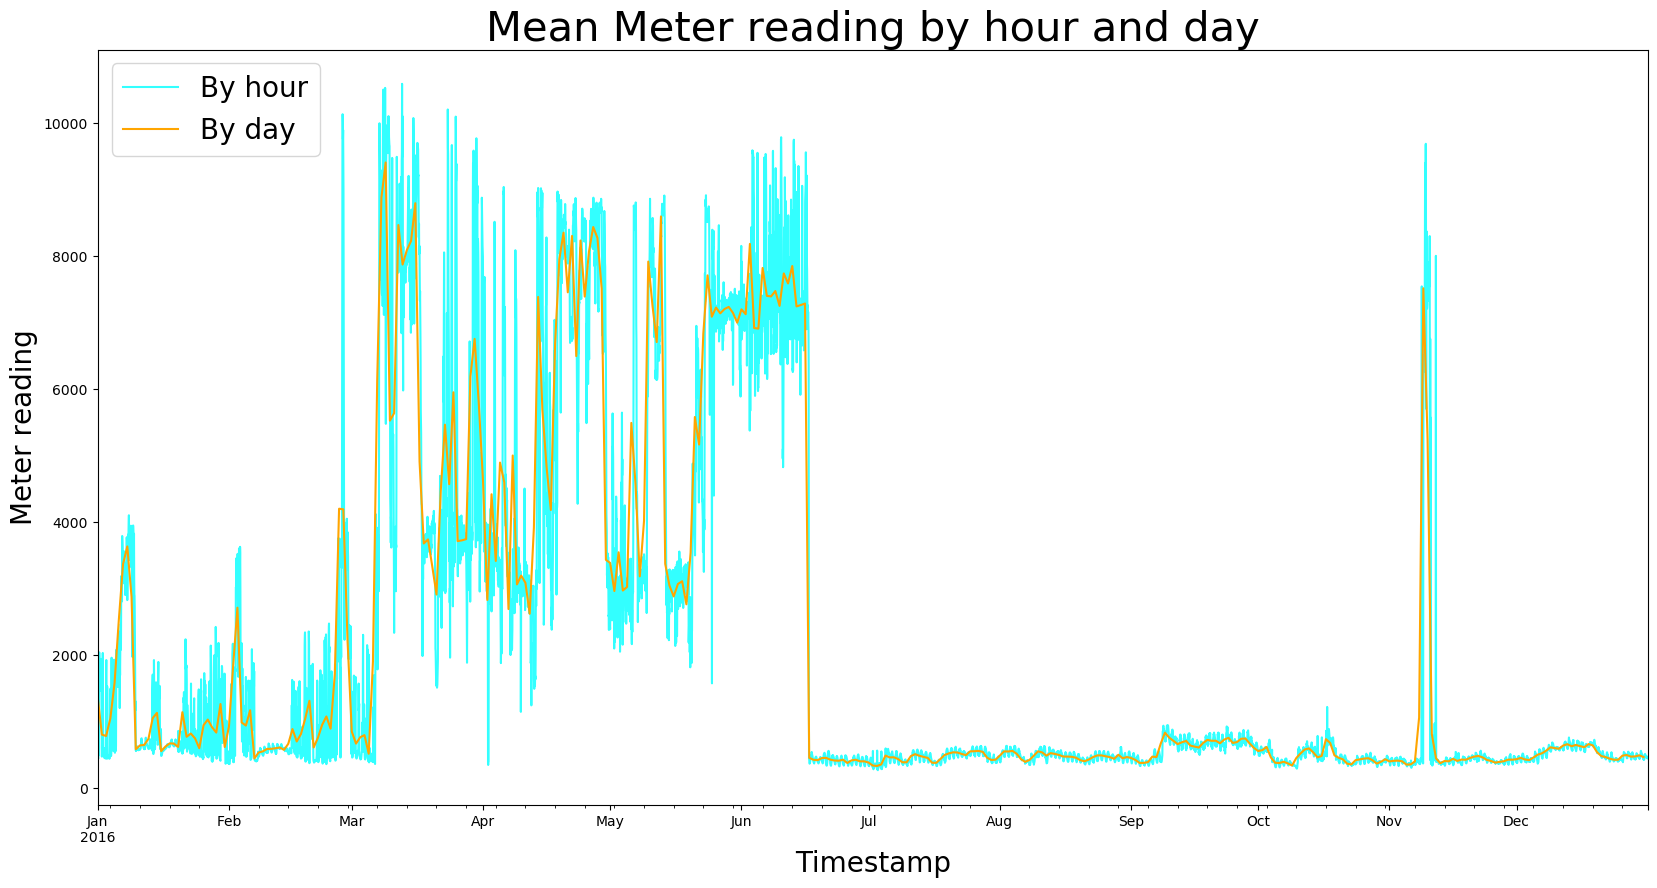

In [17]:
fig, axes = plt.subplots(figsize=(20,10), dpi=100)
H.plot(ax=axes, label='By hour', alpha=0.8, color='aqua')
D.plot(ax=axes, label='By day', alpha=1, color='orange')
axes.set_title('Mean Meter reading by hour and day', fontsize=30)
axes.set_ylabel('Meter reading', fontsize=20)
axes.set_xlabel('Timestamp', fontsize=20)
axes.legend(fontsize=20)

<Figure size 1000x1000 with 0 Axes>

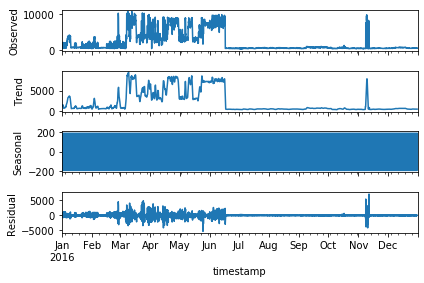

In [18]:
H_decomposition = sm.tsa.seasonal_decompose(H, model='additive')
fig = plt.figure(figsize=(10,10), dpi=100)
ax1 = H_decomposition.plot()
plt.show()

<Figure size 1000x1000 with 0 Axes>

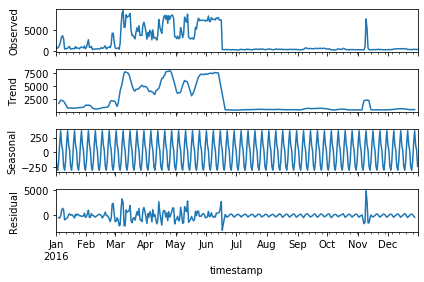

In [19]:
D_decomposition = sm.tsa.seasonal_decompose(D, model='additive')
fig = plt.figure(figsize=(10,10), dpi=100)
ax1 = D_decomposition.plot()
plt.show()

In [20]:
train['site_id'].nunique()

16

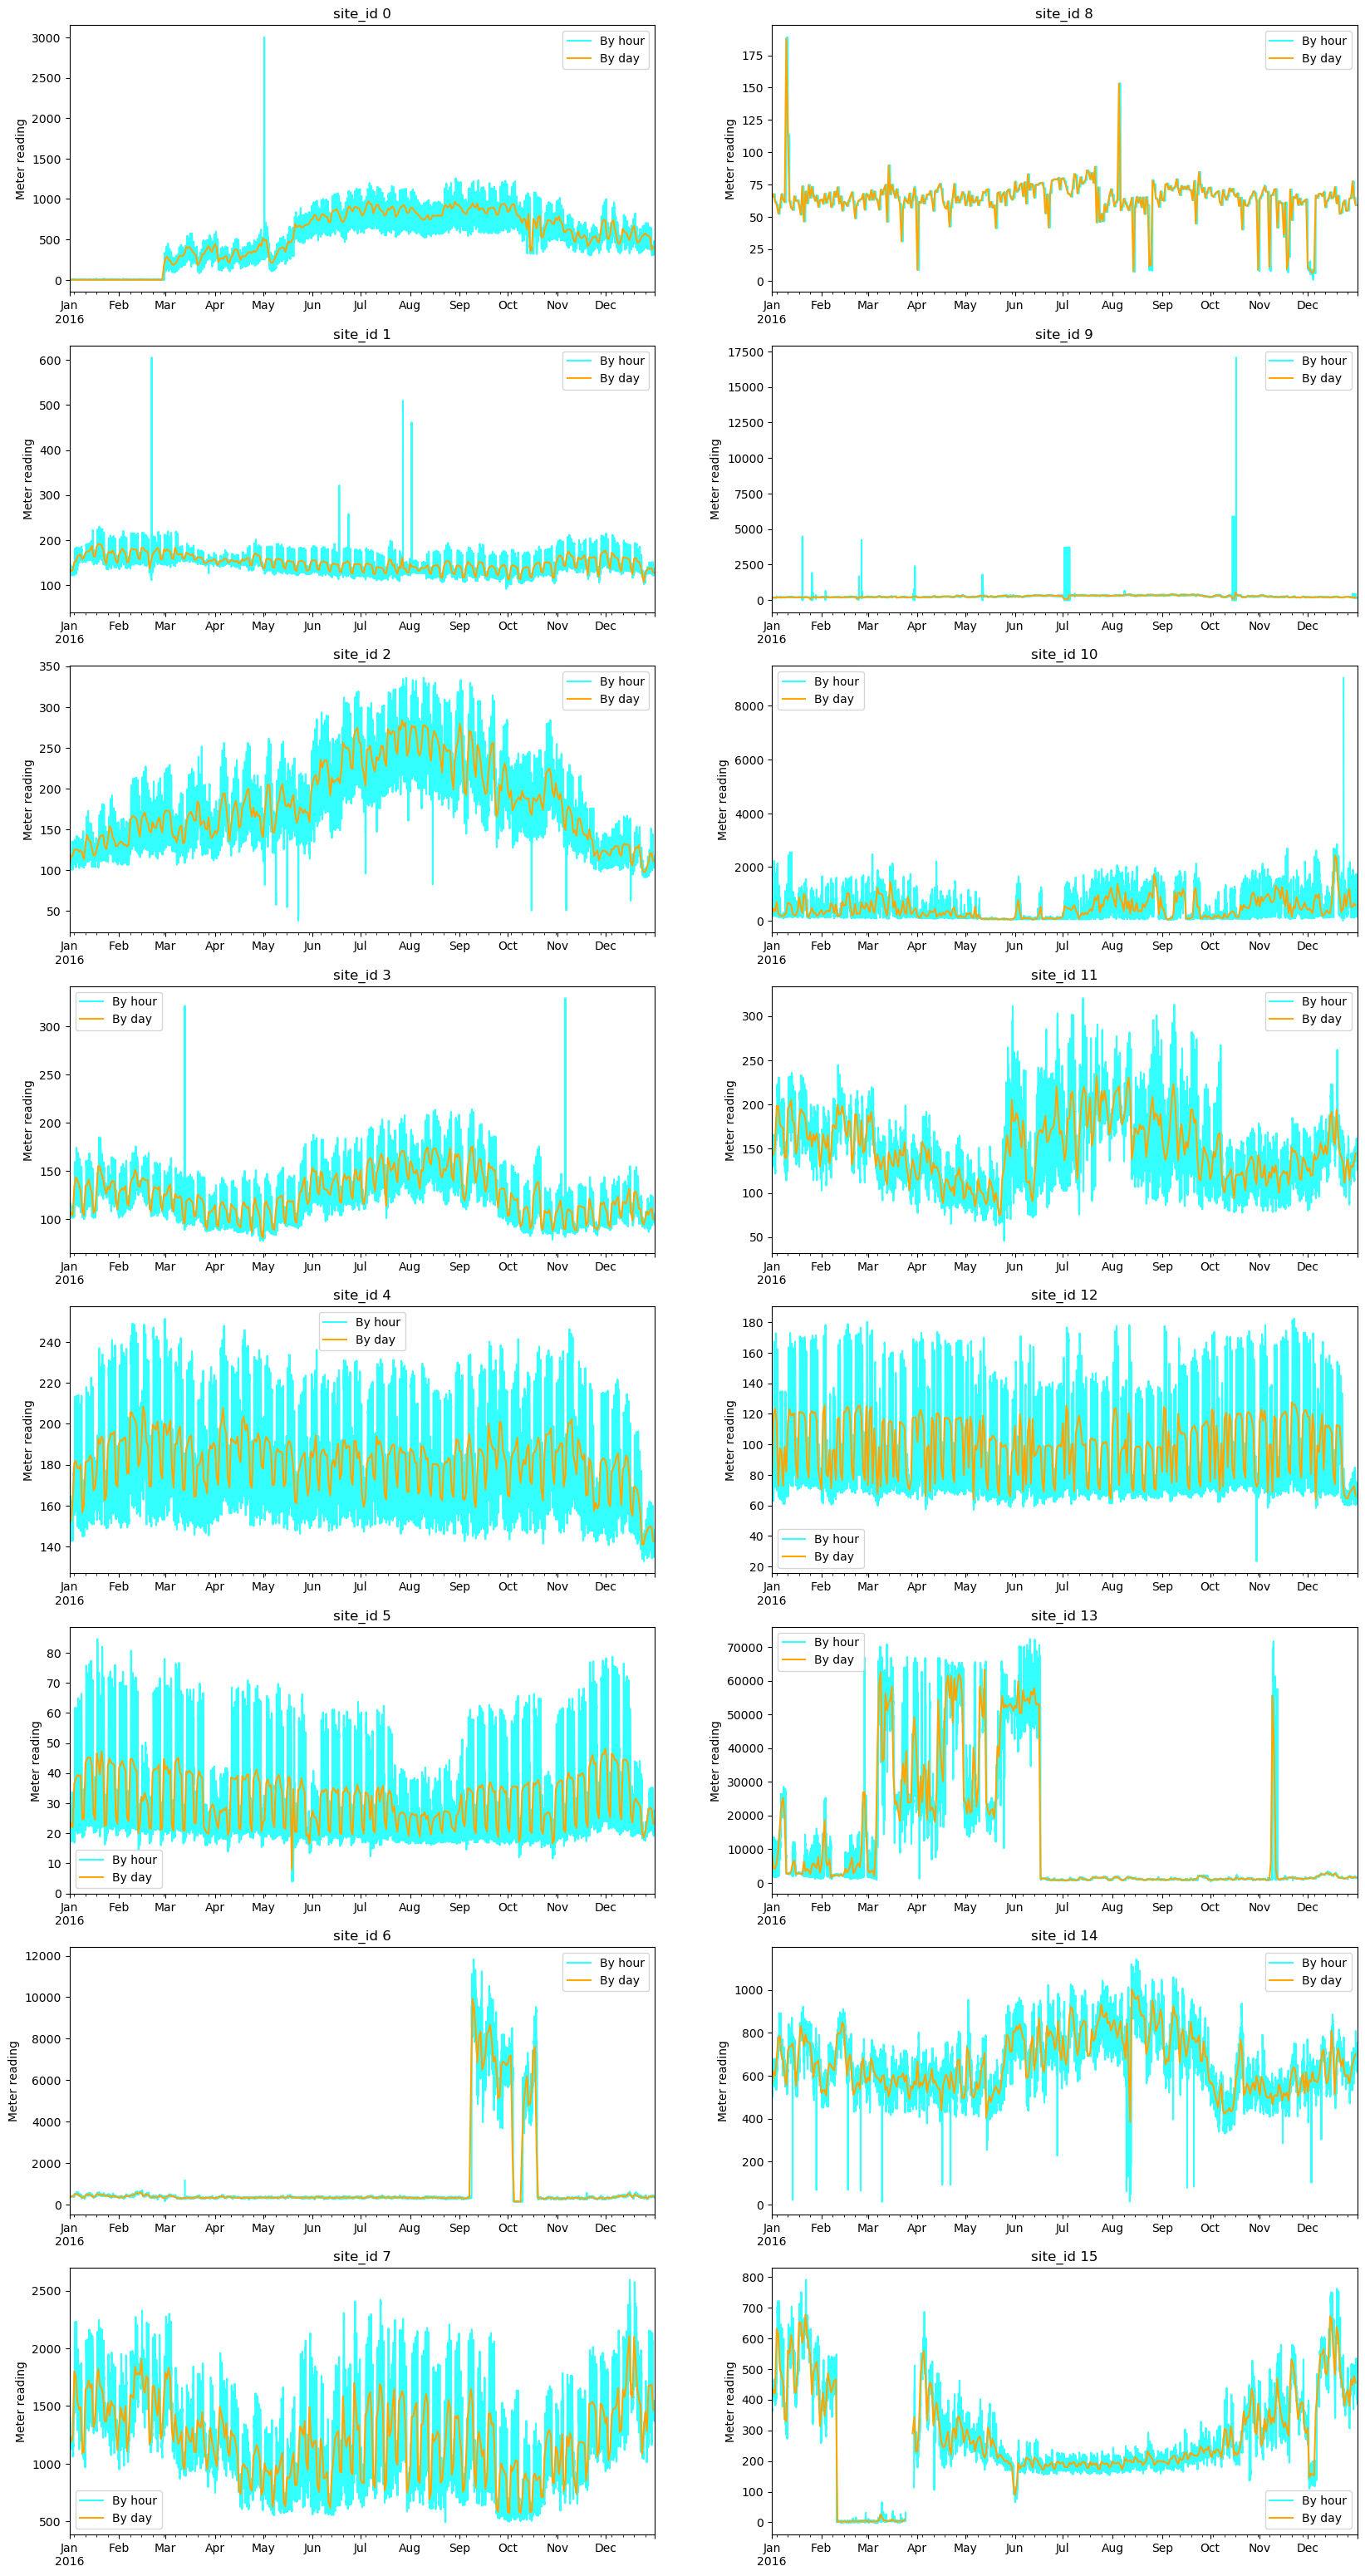

In [21]:
fig, axes = plt.subplots(8,2, figsize=(20,40), dpi=100)
for i in range(train['site_id'].nunique()):
    D = train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading']
    H = train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading']
    H.plot(ax=axes[i%8][i//8], label='By hour', alpha=0.8, color='aqua')
    D.plot(ax=axes[i%8][i//8], label='By day', alpha=1, color='orange')
    axes[i%8][i//8].set_title('site_id {}' .format(i))
    axes[i%8][i//8].set_xlabel('')
    axes[i%8][i//8].set_ylabel('Meter reading')
    axes[i%8][i//8].legend()

In [22]:
train['meter'].nunique()

4

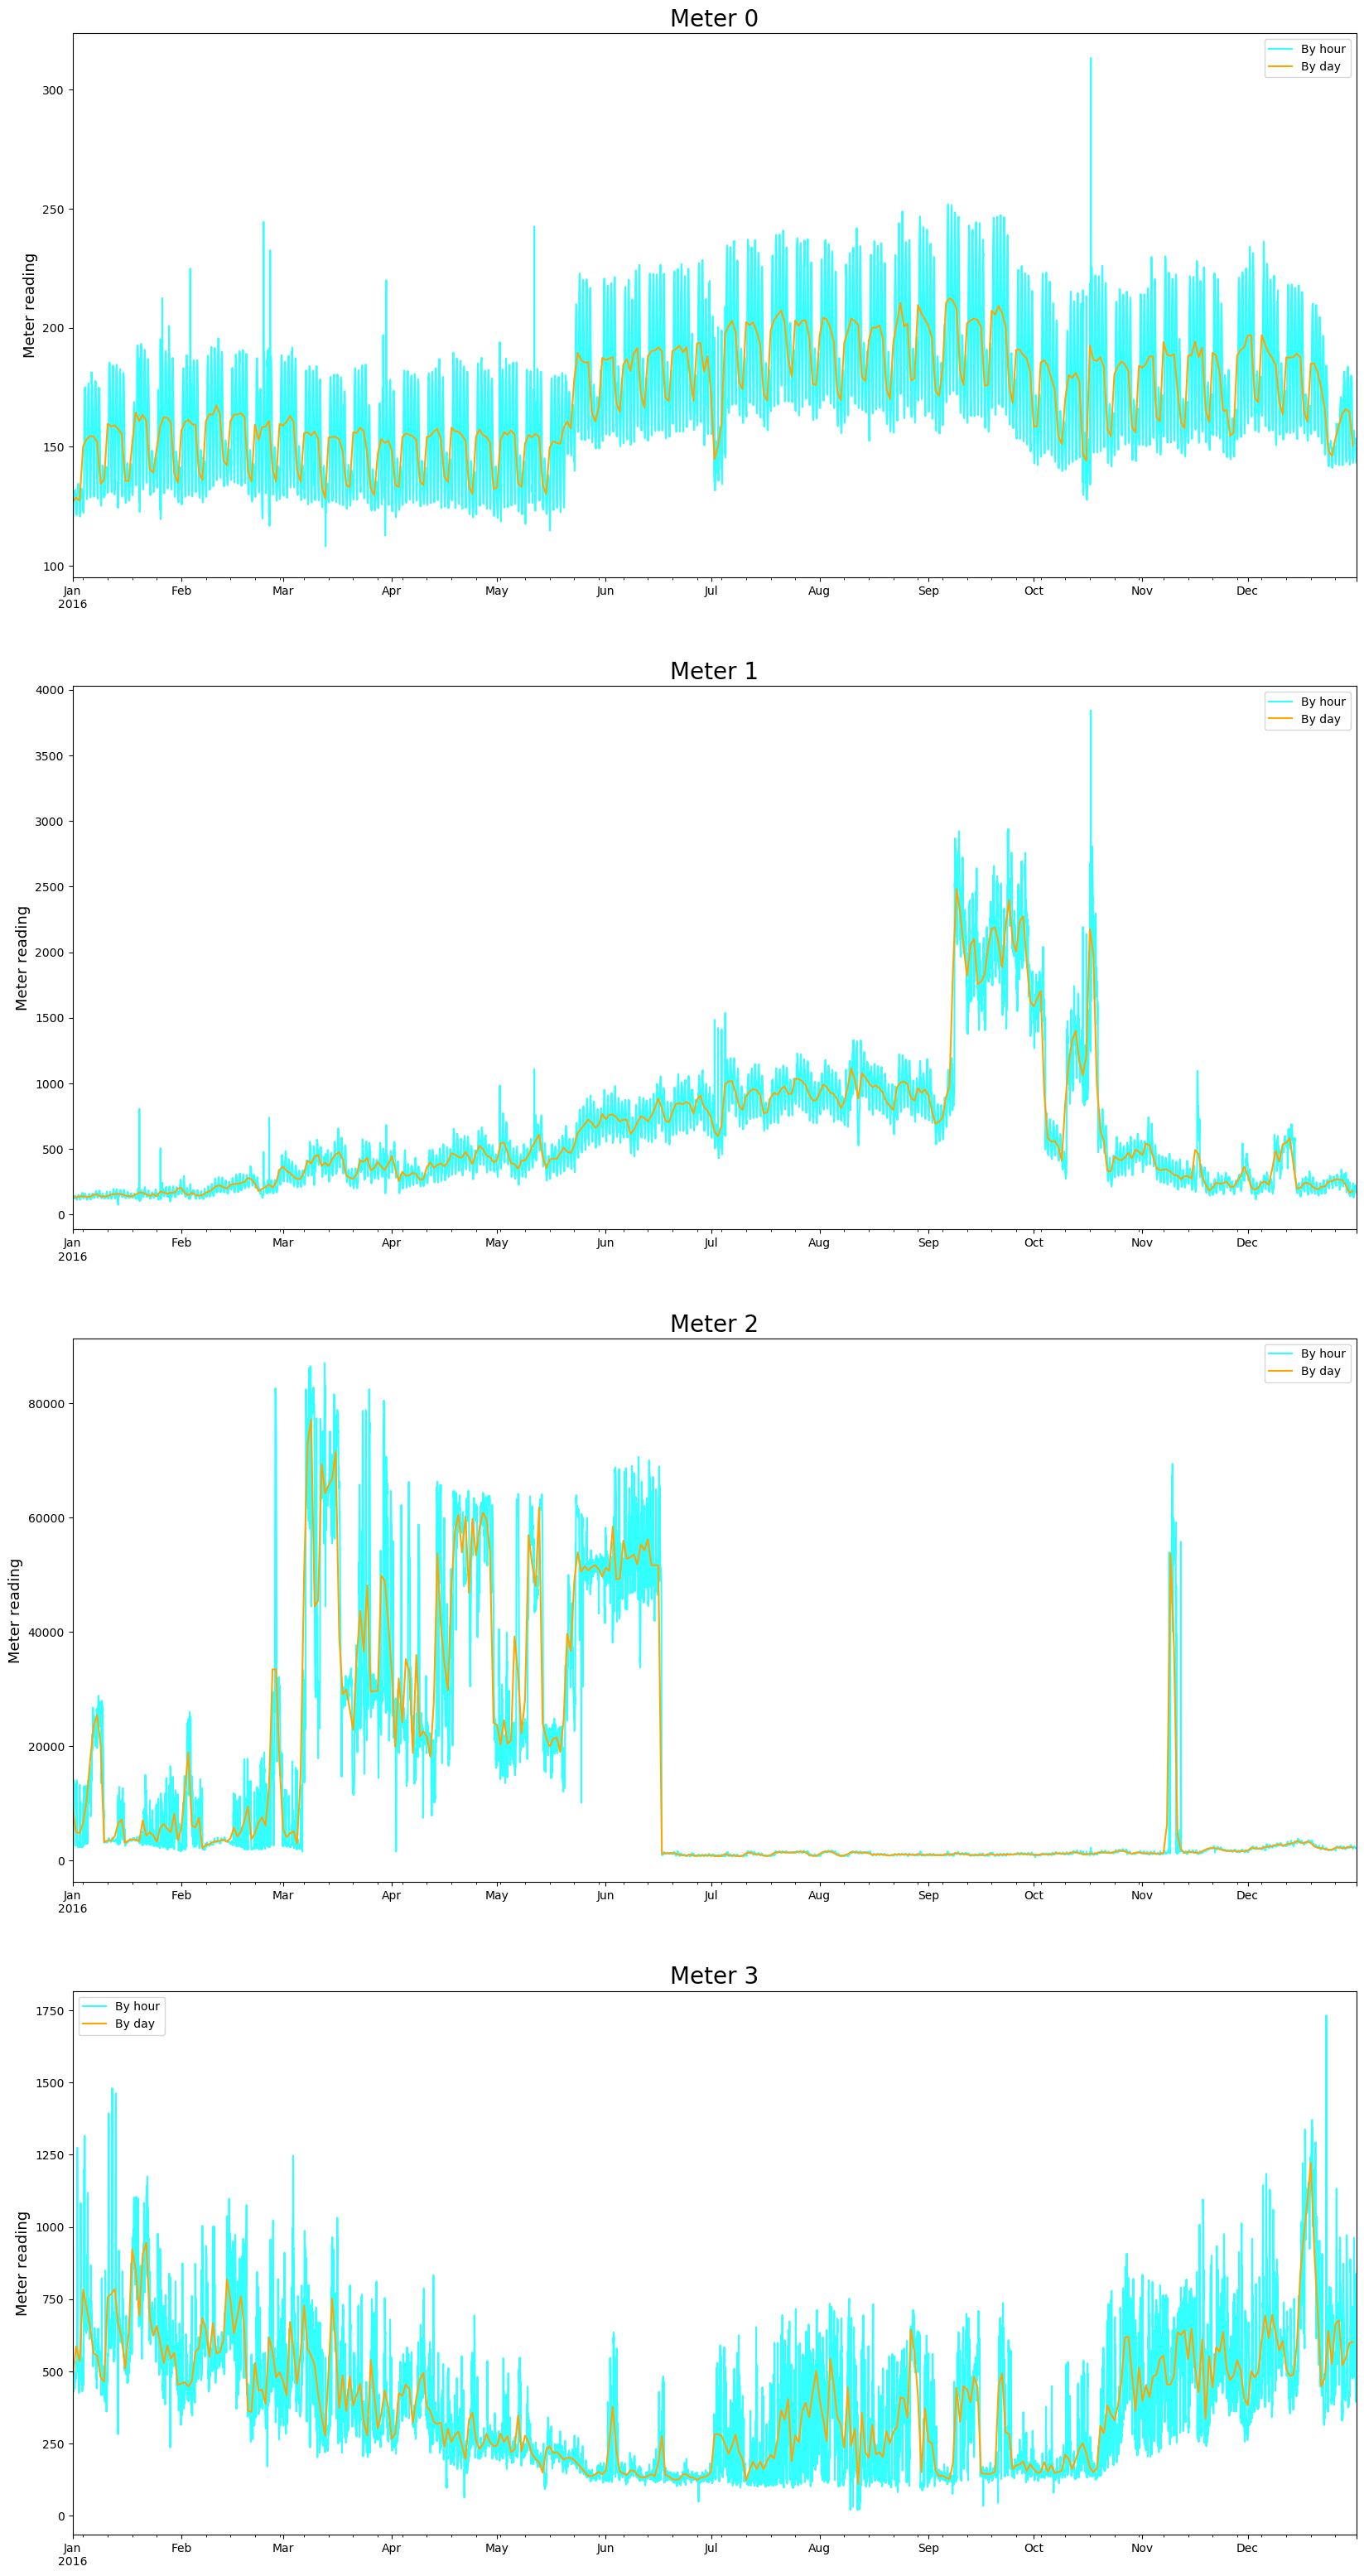

In [23]:
fig, axes = plt.subplots(4,1, figsize=(20,40), dpi=100)
for i in range(train['meter'].nunique()):
    D = train[train['meter'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading']
    H = train[train['meter'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading']
    H.plot(ax=axes[i], label='By hour', alpha=0.8, color='aqua')
    D.plot(ax=axes[i], label='By day', alpha=1, color='orange')
    axes[i].set_title('Meter {}' .format(i), fontsize=20)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Meter reading', fontsize=13)
    axes[i].legend()

In [24]:
train['primary_use'].nunique()

16

In [25]:
train['primary_use'].value_counts().index.to_list()

['Education',
 'Office',
 'Entertainment/public assembly',
 'Lodging/residential',
 'Public services',
 'Healthcare',
 'Other',
 'Parking',
 'Manufacturing/industrial',
 'Food sales and service',
 'Retail',
 'Warehouse/storage',
 'Services',
 'Technology/science',
 'Utility',
 'Religious worship']

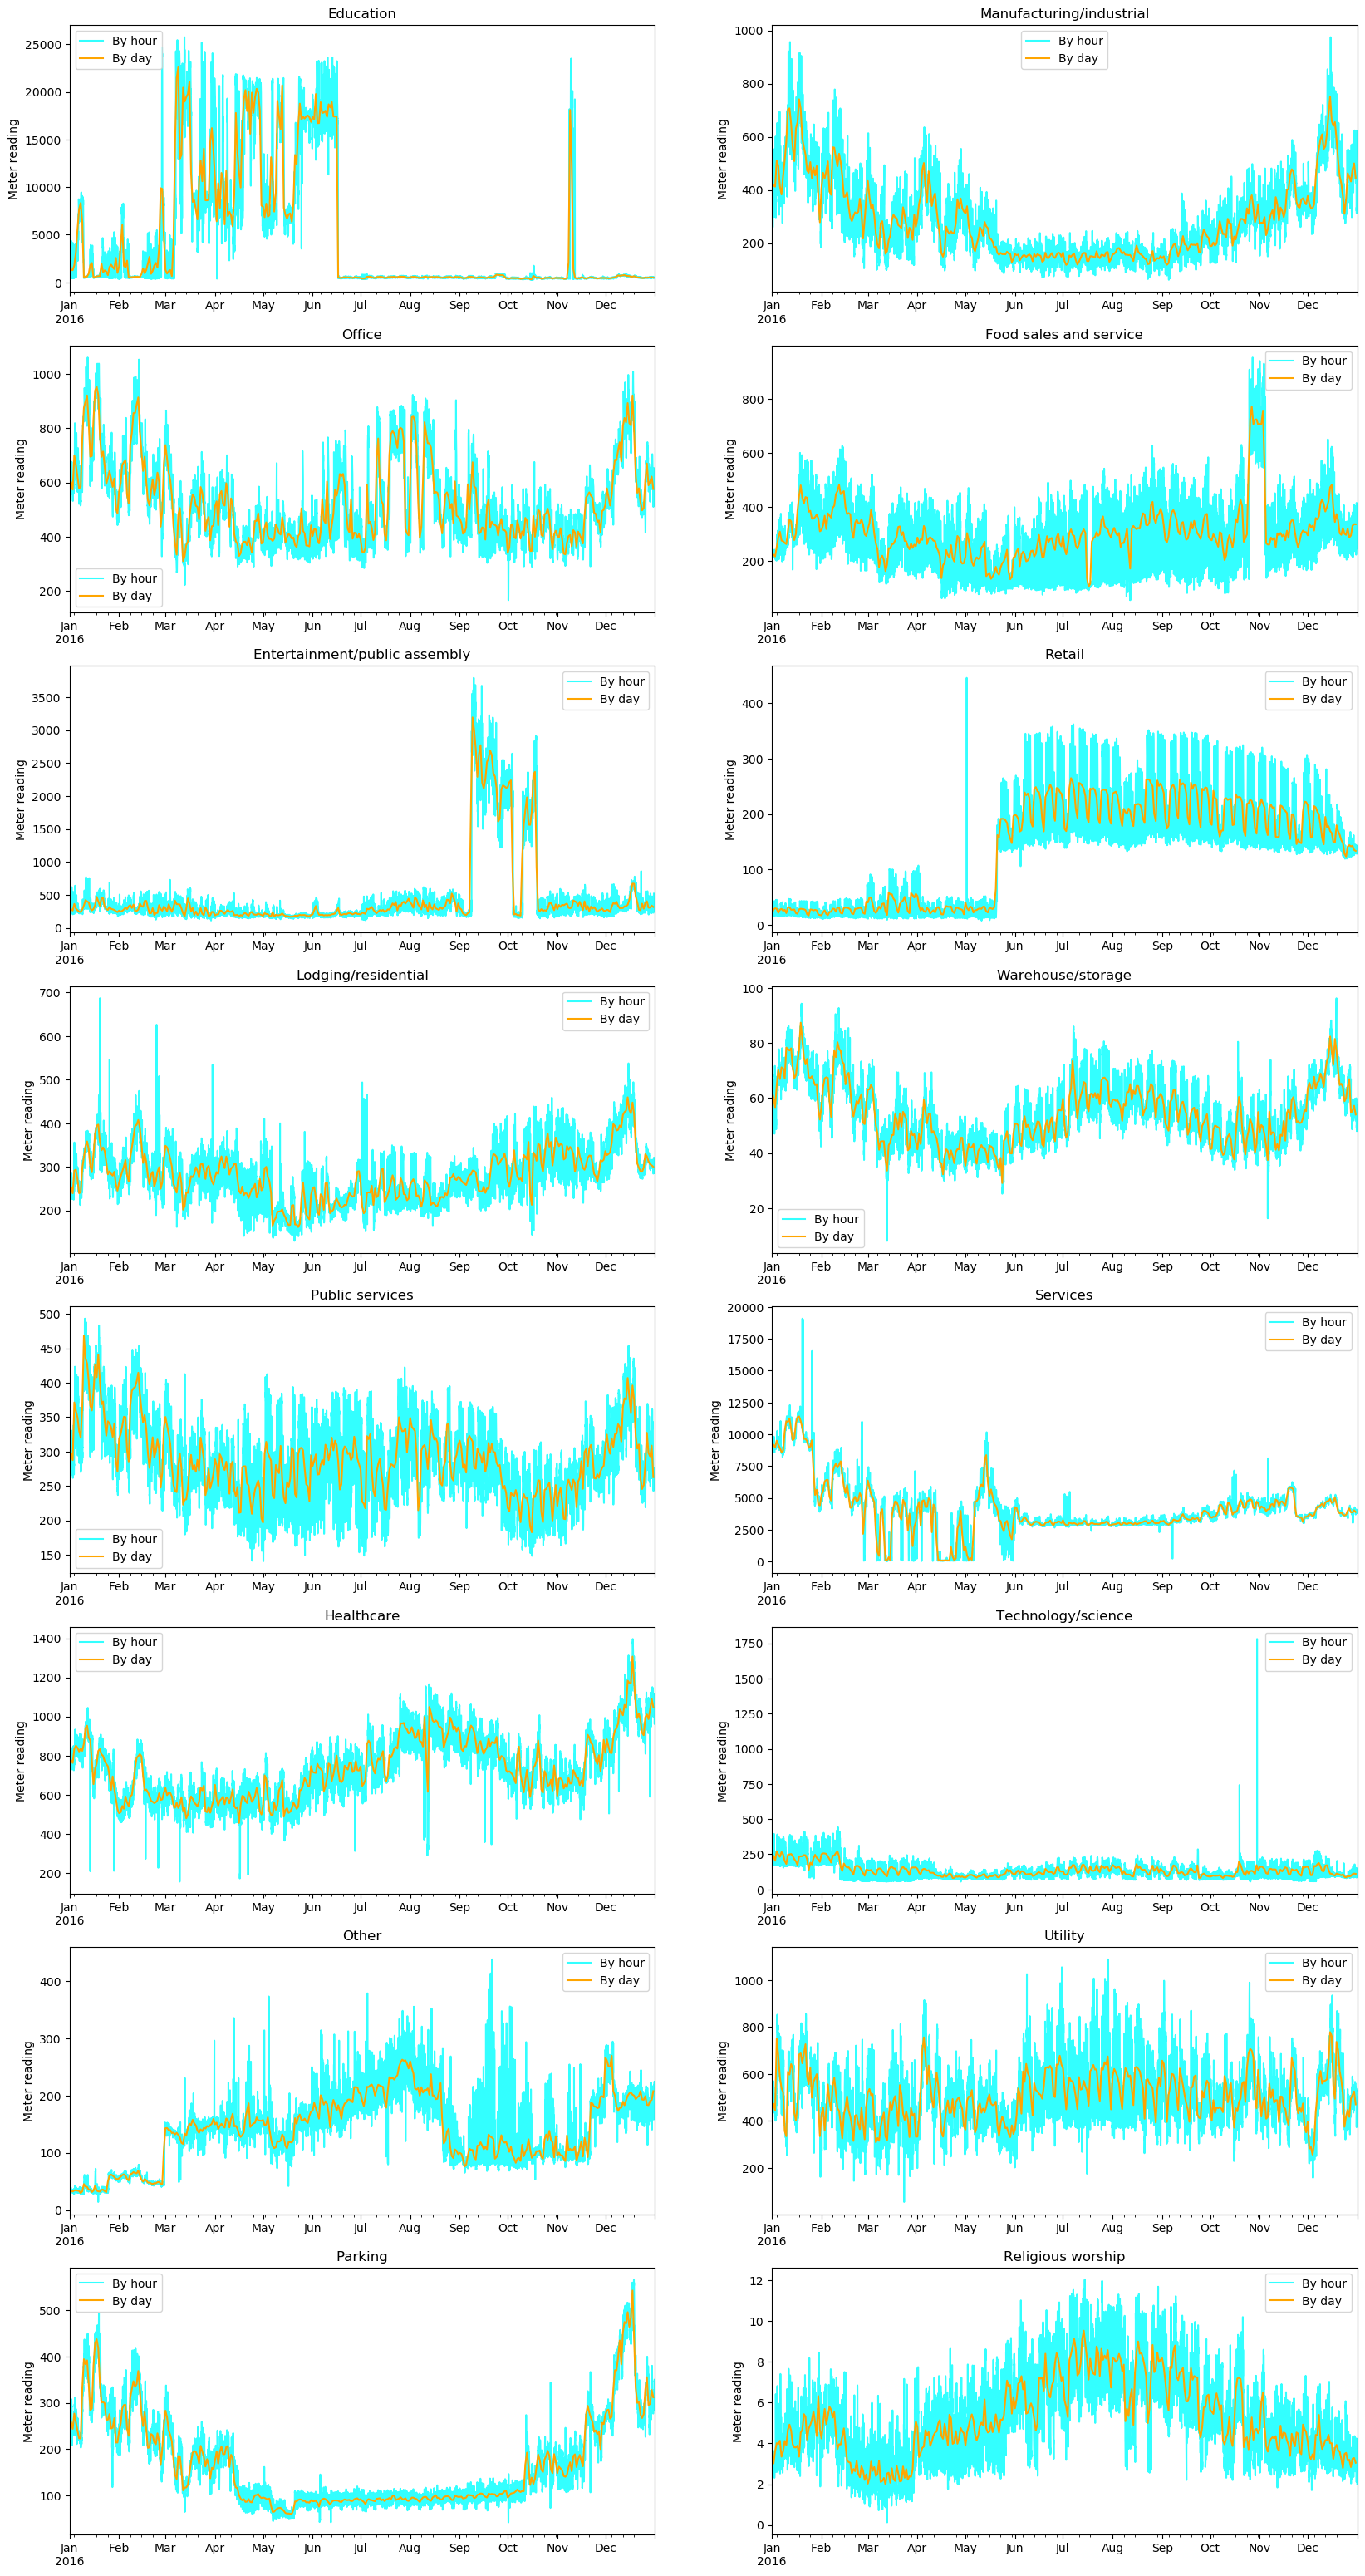

In [26]:
fig, axes = plt.subplots(8,2, figsize=(20,40), dpi=100)
for i, prim_use in enumerate(train['primary_use'].value_counts().index.to_list()):
    D = train[train['primary_use'] == prim_use][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading']
    H = train[train['primary_use'] == prim_use][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading']
    H.plot(ax=axes[i%8][i//8], label='By hour', alpha=0.8, color='aqua')
    D.plot(ax=axes[i%8][i//8], label='By day', alpha=1, color='orange')
    axes[i%8][i//8].set_title('{}' .format(prim_use))
    axes[i%8][i//8].set_xlabel('')
    axes[i%8][i//8].set_ylabel('Meter reading')
    axes[i%8][i//8].legend()

## Meter

In [54]:
train_meter_count = train['meter'].value_counts()
train_meter_per = train_meter_count/train['meter'].count()
meter_train = pd.concat([train_meter_count, train_meter_per], axis=1, keys=['Total','Percent'])
meter_train

Total   Percent
0  12060910  0.596599
1   4182440  0.206887
2   2708713  0.133988
3   1264037  0.062526

[Text(0, 0, 'electricity'),
 Text(0, 0, 'chilledwater'),
 Text(0, 0, 'steam'),
 Text(0, 0, 'hotwater')]

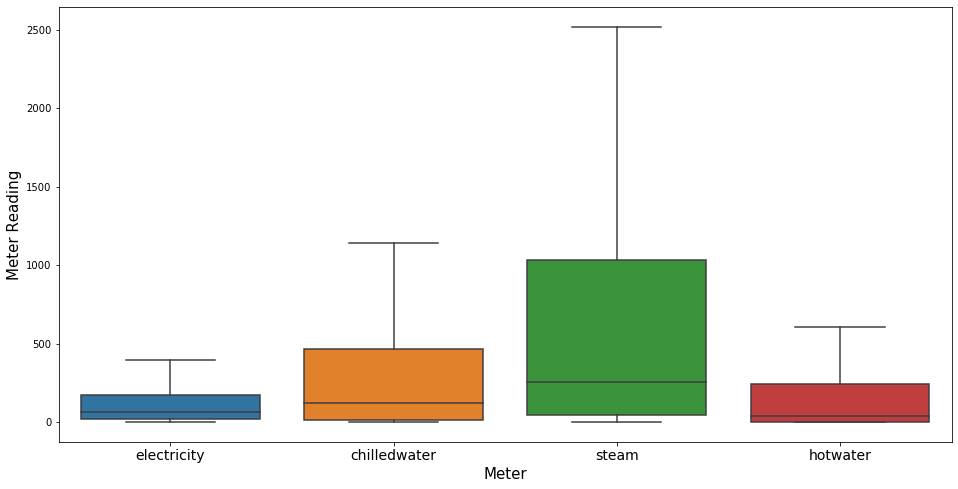

In [27]:
fig = plt.figure(figsize=(16,8))
ax = sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=False)
ax.set_xlabel('Meter', fontsize=15)
ax.set_ylabel('Meter Reading', fontsize=15)
ax.set_xticklabels(['electricity', 'chilledwater', 'steam', 'hotwater'], fontsize=14)

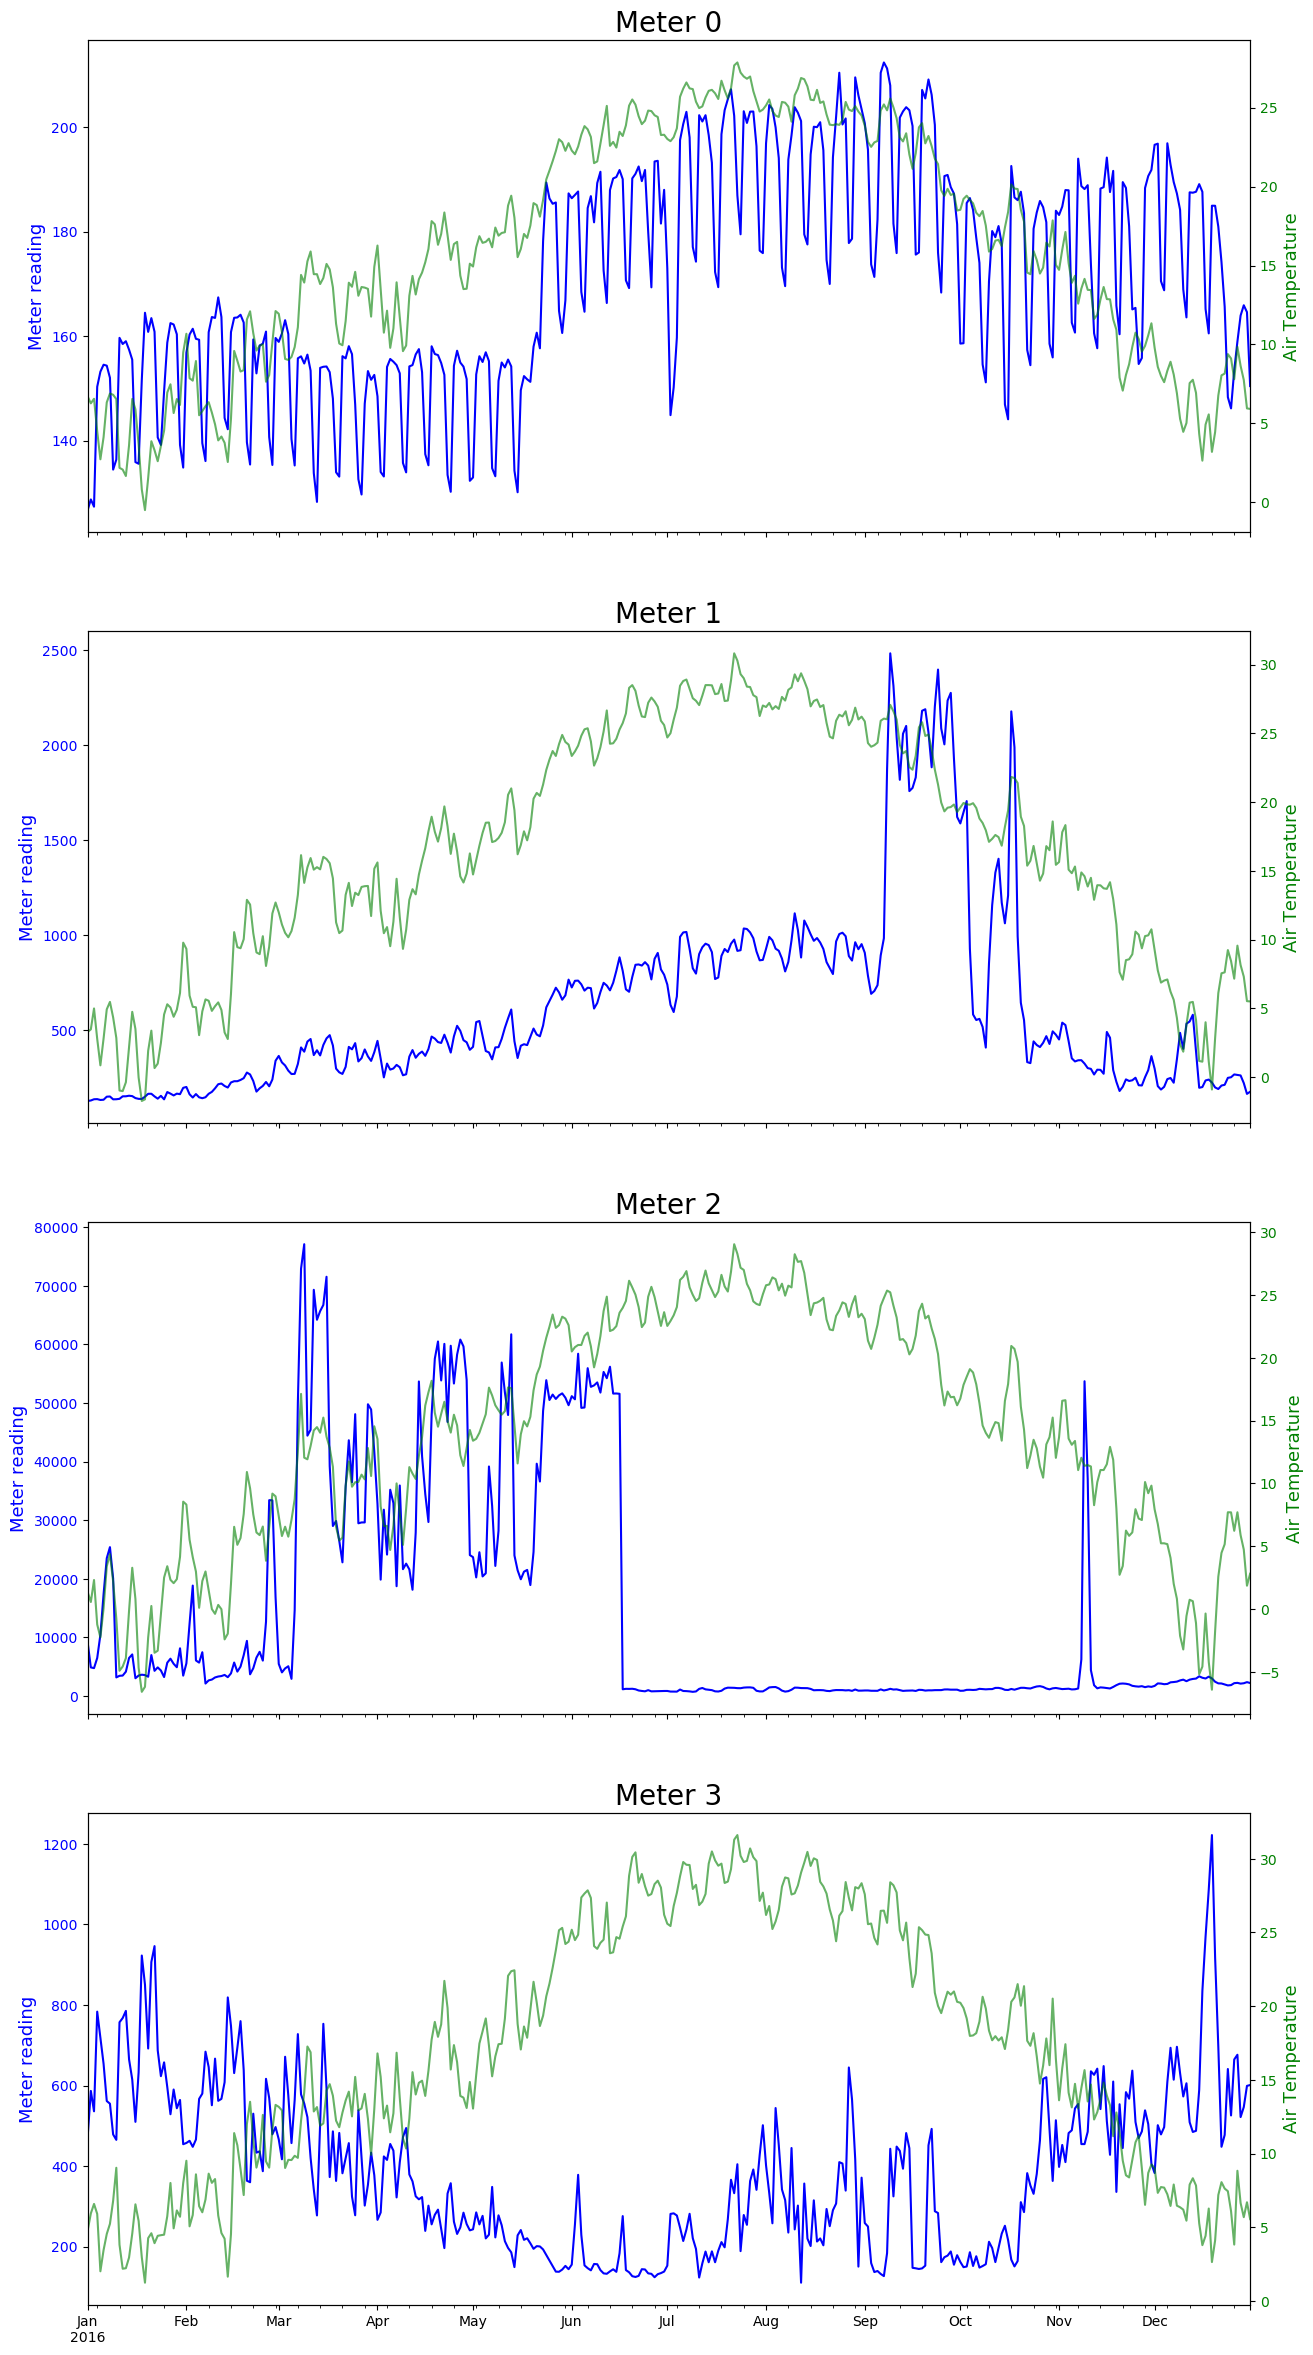

In [28]:
fig, axes = plt.subplots(4,1, figsize=(15,30), dpi=100)
axes2 = axes
for i in range(train['meter'].nunique()):
    D = train[train['meter'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading']
    T = train[train['meter'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature']
    
    
    D.plot(ax=axes[i], label='Meter Reading', alpha=1, color='blue')
    axes[i].set_title('Meter {}' .format(i), fontsize=20)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Meter reading', fontsize=13, color='blue')
    axes[i].tick_params(axis='y', labelcolor='blue')
    
    axes2[i] = axes[i].twinx()
    T.plot(ax=axes2[i], label='Air Temperature', alpha = 0.6, color='green')
    axes2[i].set_xlabel('')
    axes2[i].set_ylabel('Air Temperature', fontsize=13, color='green')
    axes2[i].tick_params(axis='y', labelcolor='green')

## site_id

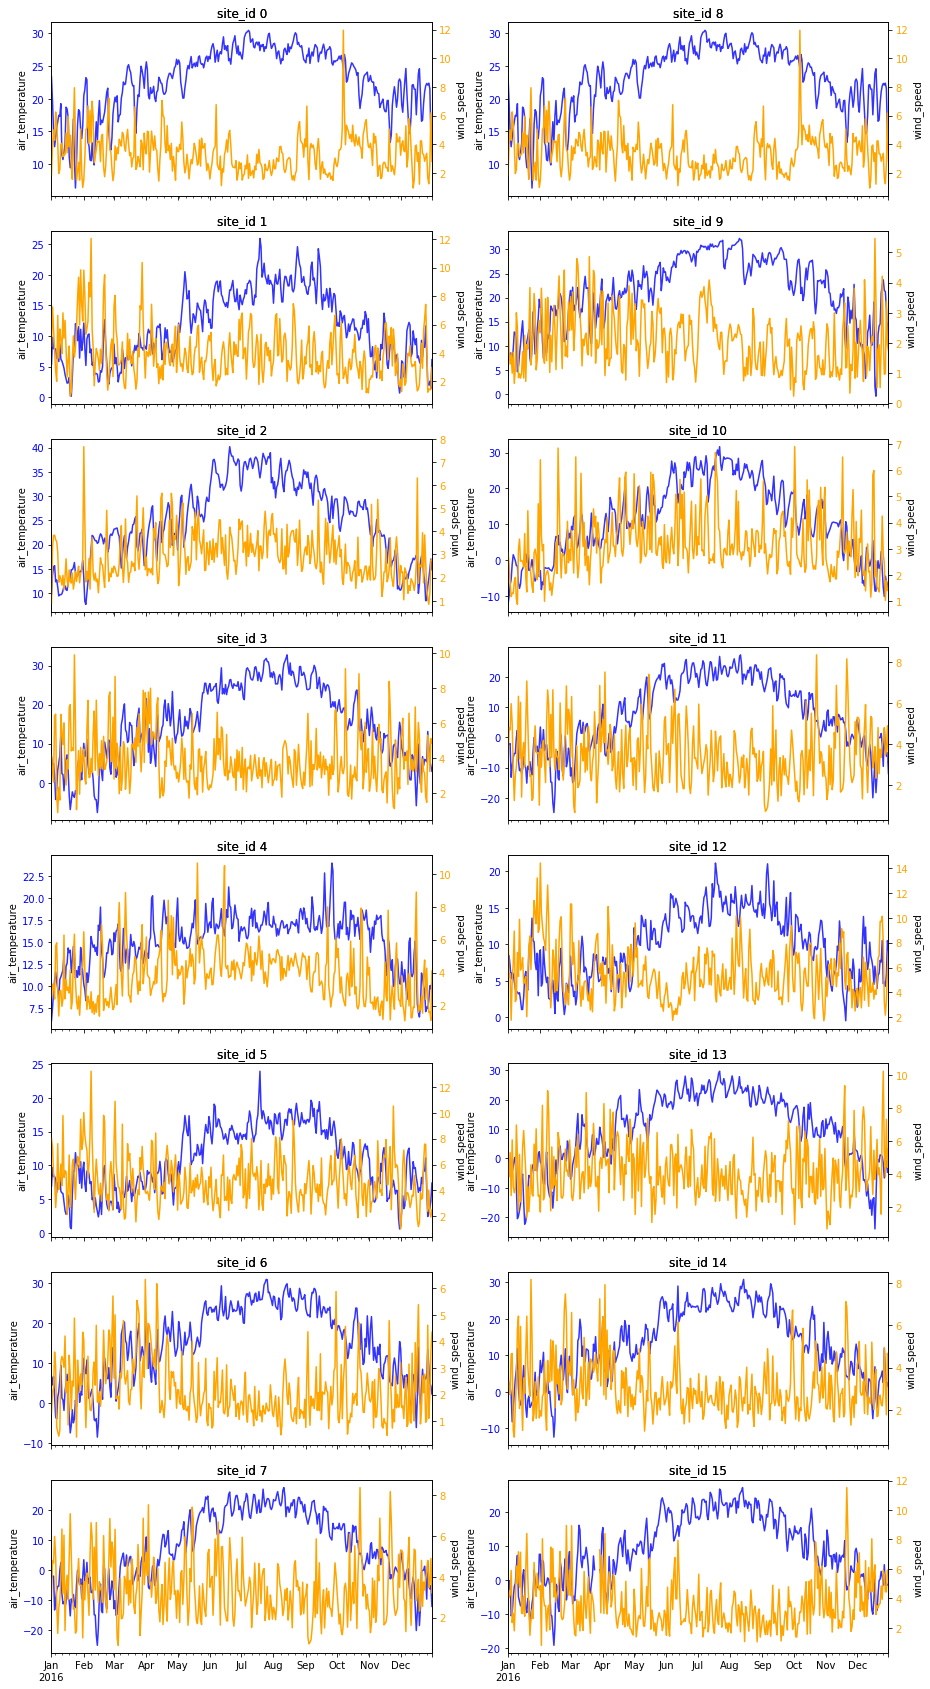

In [29]:
fig, axes = plt.subplots(8,2, figsize=(15,30))
axes2 = axes
for i in range(train['site_id'].nunique()):
    air_temp = train[train['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature']
    air_temp.plot(ax=axes[i%8][i//8], label='air_temperature', alpha=0.8, color='blue')
    axes[i%8][i//8].set_title('site_id {}' .format(i))
    axes[i%8][i//8].set_xlabel('')
    axes[i%8][i//8].set_ylabel('air_temperature')
    axes[i%8][i//8].tick_params(axis='y', labelcolor='blue')

    axes2[i%8][i//8] = axes[i%8][i//8].twinx()
    wind = train[train['site_id'] == i][['timestamp', 'wind_speed']].set_index('timestamp').resample('D').mean()['wind_speed']
    wind.plot(ax=axes2[i%8][i//8], label='wind_speed', alpha=1, color='orange')
    axes2[i%8][i//8].set_title('site_id {}' .format(i))
    axes2[i%8][i//8].set_xlabel('')
    axes2[i%8][i//8].set_ylabel('wind_speed')
    axes2[i%8][i//8].tick_params(axis='y', labelcolor='orange')

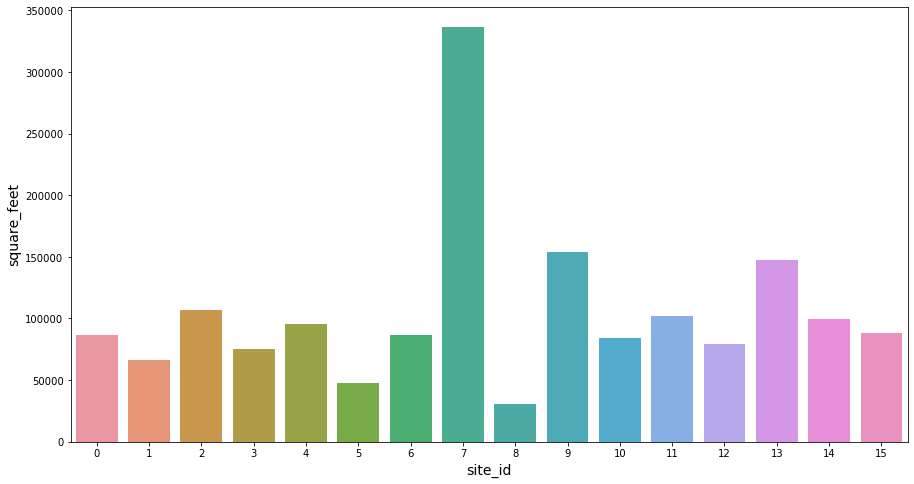

In [88]:
df = train[['site_id', 'square_feet']]
sites = list(range(0,16,1))

sq_fts = []*train['site_id'].nunique()
for i in range(train['site_id'].nunique()):
    area = df[df['site_id'] == i]['square_feet'].mean()
    sq_fts.append(area)
    
area_df = pd.DataFrame({'site_id': sites, 'square_feet': sq_fts})

fig = plt.figure(figsize=(15,8))
ax = sns.barplot(x='site_id', y='square_feet', data=area_df)
ax.set_xlabel('site_id', fontsize=14)
ax.set_ylabel('square_feet', fontsize=14)
plt.show()

## primary_use

In [101]:
train_use_count = train['primary_use'].value_counts()
train_use_per = train_use_count/train['primary_use'].count()
use_train = pd.concat([train_use_count, train_use_per], axis=1, keys=['Total','Percent']).reset_index()
use_train = use_train.rename(columns = {'index': 'primary_use'})
use_train

primary_use    Total   Percent
0                       Education  8165504  0.403911
1                          Office  4394864  0.217394
2   Entertainment/public assembly  2264917  0.112035
3             Lodging/residential  2146413  0.106173
4                 Public services  1662826  0.082253
5                      Healthcare   398527  0.019713
6                           Other   242222  0.011982
7                         Parking   213796  0.010576
8        Manufacturing/industrial   125713  0.006218
9          Food sales and service   114090  0.005644
10                         Retail   112657  0.005573
11              Warehouse/storage   111861  0.005533
12                       Services    96519  0.004774
13             Technology/science    77627  0.003840
14                        Utility    56203  0.002780
15              Religious worship    32361  0.001601

In [102]:
fig = px.pie(use_train, values='Percent', names='primary_use')
fig.show()

In [110]:
train_use_consumption = train[['primary_use', 'meter_reading']]
use_list = train['primary_use'].value_counts().index.to_list()
readings = []*len(use_list)

for i in use_list:
    reading = train_use_consumption[train_use_consumption['primary_use'] == i]['meter_reading'].sum()
    readings.append(reading)

reading_percent = readings / train_use_consumption['meter_reading'].sum()
use_df = pd.DataFrame({'primary_use': use_list, 'total_meter_reading': readings, 'percent_meter_reading': reading_percent})

In [115]:
fig = px.pie(use_df, values='percent_meter_reading', names='primary_use')
fig.show()

## square_feet

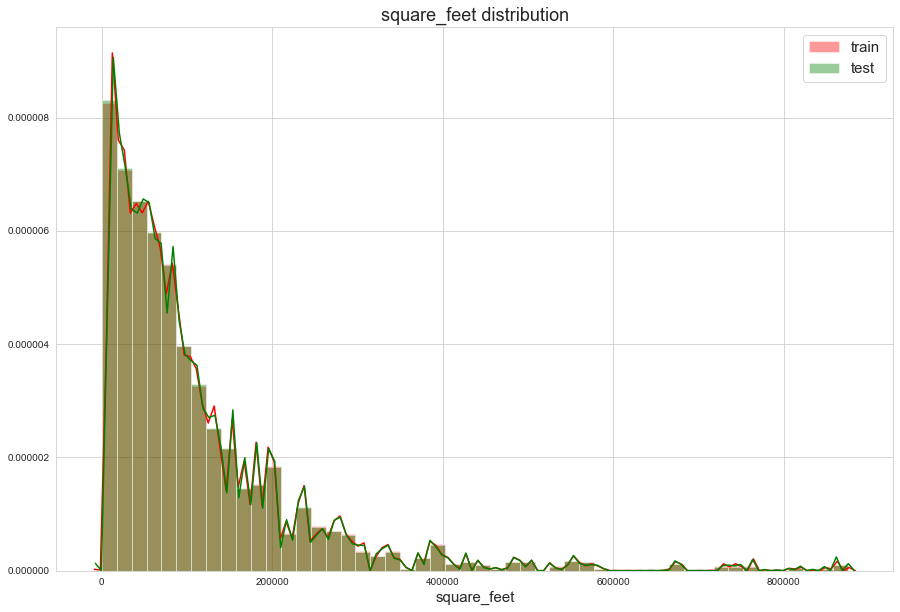

In [30]:
dist_plot('square_feet')

In [58]:
train.groupby('site_id')['square_feet', 'floor_count'].mean()

square_feet  floor_count
site_id                            
0         86411.509331          NaN
1         65927.879047     6.921875
2        107127.861840          NaN
3         75146.897262          NaN
4         95214.353837     5.394531
5         47612.415730     2.281250
6         86764.852591          NaN
7        336180.920397     9.101562
8         30176.135099     1.014648
9        153960.553432          NaN
10        83895.280331     2.193359
11       101706.323693          NaN
12        79332.135324     2.777344
13       147856.984767          NaN
14        99372.283937          NaN
15        88035.487767          NaN

In [54]:
train.groupby('primary_use')['square_feet','floor_count'].mean()

square_feet  floor_count
primary_use                                              
Education                      119998.782690     5.246094
Entertainment/public assembly  106256.004265     2.093750
Food sales and service          39635.179683          NaN
Healthcare                     138438.671365     1.000000
Lodging/residential            100830.731729     6.382812
Manufacturing/industrial        42169.498739     1.666992
Office                          96837.479905     3.851562
Other                           29122.550755     1.067383
Parking                        287217.872594     3.125000
Public services                 88863.278151     2.277344
Religious worship               13307.828775          NaN
Retail                          41034.131106     1.500000
Services                       186846.917705          NaN
Technology/science              66740.011220     5.304688
Utility                         31514.537462     2.000000
Warehouse/storage               46210.507514     1.000000

## buliding_id

Text(0, 0.5, 'mean meter reading')

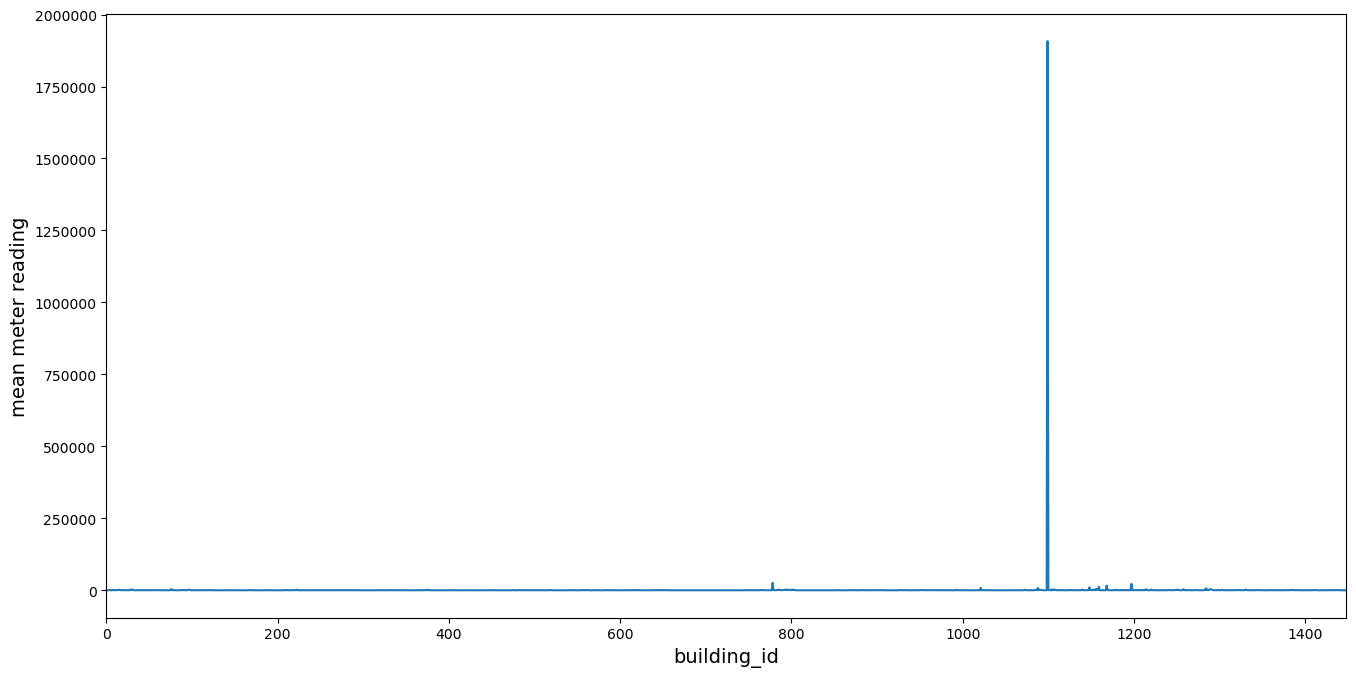

In [84]:
fig = plt.figure(figsize=(16,8), dpi=100)
ax = train.groupby('building_id')['meter_reading'].mean().plot()
ax.set_xlabel('building_id', fontsize=14)
ax.set_ylabel('mean meter reading', fontsize=14)

In [95]:
build_outlier = train.groupby('building_id')['meter_reading'].mean().idxmax()
train[train['building_id'] == build_outlier]

building_id  meter           timestamp  meter_reading  site_id  \
1533             1099      0 2016-01-01 00:00:00   2.822480e+02       13   
1534             1099      2 2016-01-01 00:00:00   3.241630e+06       13   
3829             1099      0 2016-01-01 01:00:00   2.822480e+02       13   
3830             1099      2 2016-01-01 01:00:00   3.241630e+06       13   
6125             1099      0 2016-01-01 02:00:00   2.848640e+02       13   
6126             1099      2 2016-01-01 02:00:00   2.625840e+05       13   
8424             1099      0 2016-01-01 03:00:00   2.802870e+02       13   
8425             1099      2 2016-01-01 03:00:00   2.263200e+04       13   
10719            1099      0 2016-01-01 04:00:00   2.799750e+02       13   
10720            1099      2 2016-01-01 04:00:00   1.608960e+05       13   
13014            1099      0 2016-01-01 05:00:00   2.911070e+02       13   
13015            1099      2 2016-01-01 05:00:00   1.896620e+06       13   
15308            1099      0 2016-01-01 06:00:00   3.146400e+02       13   
15309            1099      2 2016-01-01 06:00:00   6.244800e+04       13   
17600            1099      0 2016-01-01 07:00:00   3.206450e+02       13   
17601            1099      2 2016-01-01 07:00:00   3.012000e+04       13   
19895            1099      0 2016-01-01 08:00:00   3.223650e+02       13   
19896            1099      2 2016-01-01 08:00:00   2.608800e+05       13   
22190            1099      0 2016-01-01 09:00:00   3.014190e+02       13   
22191            1099      2 2016-01-01 09:00:00   3.554740e+06       13   
24487            1099      0 2016-01-01 10:00:00   3.030710e+02       13   
24488            1099      2 2016-01-01 10:00:00   3.341210e+06       13   
26786            1099      0 2016-01-01 11:00:00   3.012470e+02       13   
26787            1099      2 2016-01-01 11:00:00   2.695780e+06       13   
29082            1099      0 2016-01-01 12:00:00   3.015290e+02       13   
29083            1099      2 2016-01-01 12:00:00   2.608420e+06       13   
31380            1099      0 2016-01-01 13:00:00   3.126580e+02       13   
31381            1099      2 2016-01-01 13:00:00   2.583650e+06       13   
33677            1099      0 2016-01-01 14:00:00   3.131710e+02       13   
33678            1099      2 2016-01-01 14:00:00   2.670430e+06       13   
...               ...    ...                 ...            ...      ...   
20182233         1099      0 2016-12-31 09:00:00   2.959880e+02       13   
20182234         1099      2 2016-12-31 09:00:00   9.048000e+03       13   
20184593         1099      0 2016-12-31 10:00:00   3.523360e+02       13   
20184594         1099      2 2016-12-31 10:00:00   9.192000e+03       13   
20186954         1099      0 2016-12-31 11:00:00   3.996550e+02       13   
20186955         1099      2 2016-12-31 11:00:00   8.544000e+03       13   
20189315         1099      0 2016-12-31 12:00:00   4.089370e+02       13   
20189316         1099      2 2016-12-31 12:00:00   8.544000e+03       13   
20191676         1099      0 2016-12-31 13:00:00   4.142440e+02       13   
20191677         1099      2 2016-12-31 13:00:00   8.352000e+03       13   
20194039         1099      0 2016-12-31 14:00:00   4.132330e+02       13   
20194040         1099      2 2016-12-31 14:00:00   7.944000e+03       13   
20196404         1099      0 2016-12-31 15:00:00   4.116250e+02       13   
20196405         1099      2 2016-12-31 15:00:00   8.064000e+03       13   
20198769         1099      0 2016-12-31 16:00:00   4.133880e+02       13   
20198770         1099      2 2016-12-31 16:00:00   8.088000e+03       13   
20201134         1099      0 2016-12-31 17:00:00   3.577150e+02       13   
20201135         1099      2 2016-12-31 17:00:00   8.712000e+03       13   
20203497         1099      0 2016-12-31 18:00:00   3.172530e+02       13   
20203498         1099      2 2016-12-31 18:00:00   9.072000e+03       13   
20205860         1099      0 2016-12-31 19:00:00   2.99058

Text(0, 0.5, 'mean meter reading')

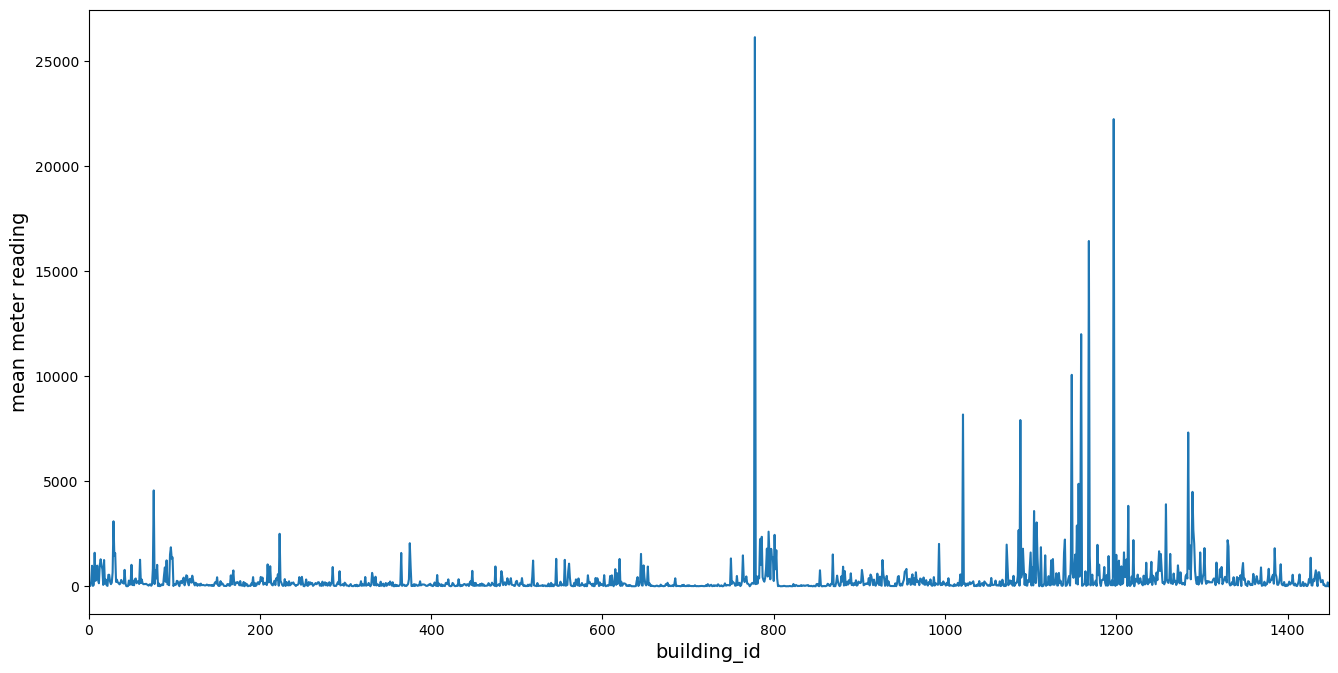

In [96]:
fig = plt.figure(figsize=(16,8), dpi=100)
ax = train[train['building_id'] != build_outlier].groupby('building_id')['meter_reading'].mean().plot()
ax.set_xlabel('building_id', fontsize=14)
ax.set_ylabel('mean meter reading', fontsize=14)

## floor_count

Text(0.5, 0, 'floor_count_test')

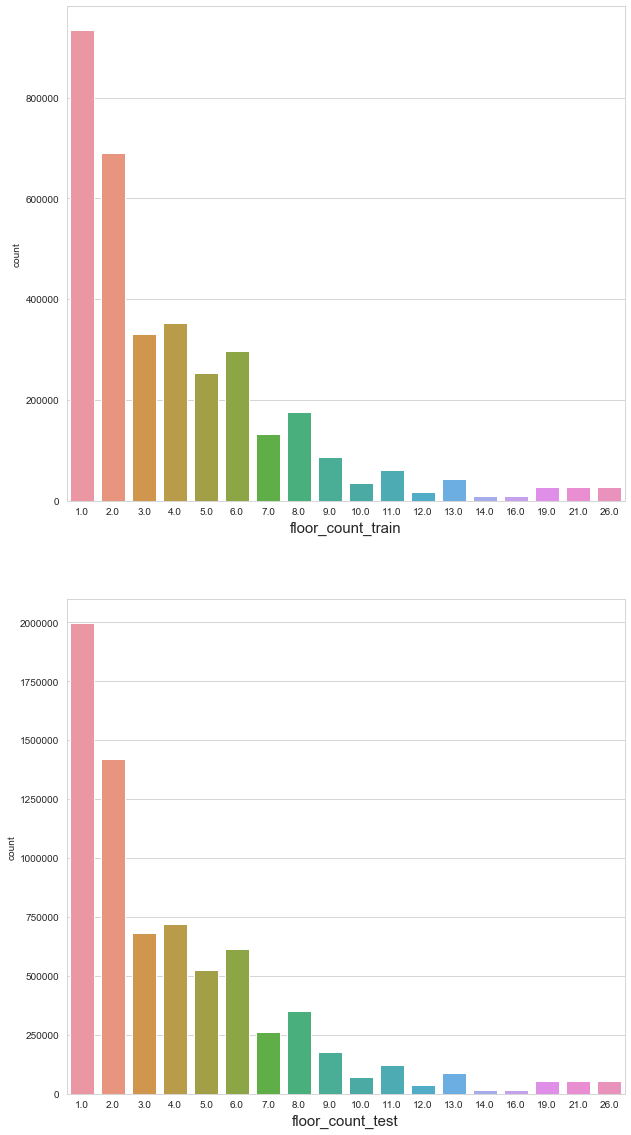

In [36]:
fig = plt.figure(figsize=(10,20))

ax1 = plt.subplot(2,1,1)
sns.countplot(x='floor_count', data = train)
ax1.set_xlabel('floor_count_train', fontsize=15)

ax2 = plt.subplot(2,1,2)
sns.countplot(x='floor_count', data = test)
ax2.set_xlabel('floor_count_test', fontsize=15)

Text(0, 0.5, 'mean_meter_reading')

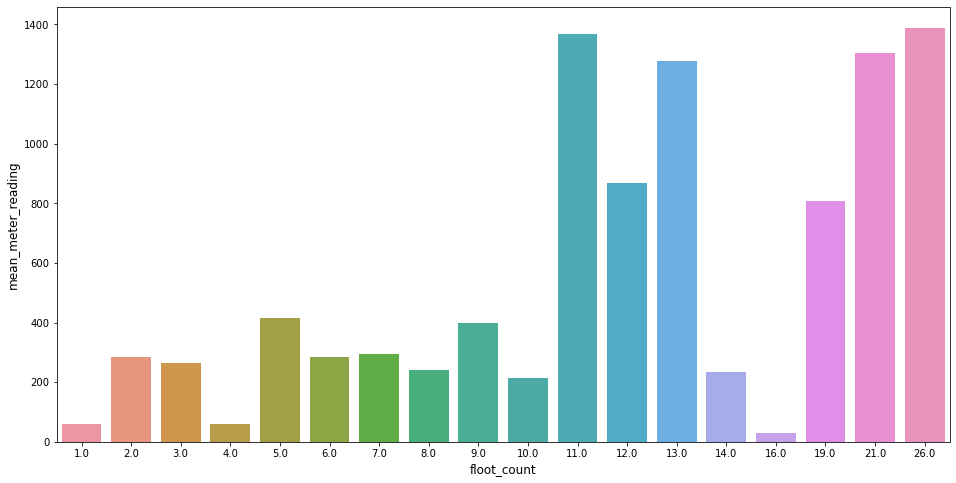

In [75]:
floor = train.groupby('floor_count')['meter_reading'].mean().sort_index()
floor_df = pd.DataFrame({'floor_count': floor.index, 'mean_meter_reading': floor.values})

fig = plt.figure(figsize=(16,8))
ax = sns.barplot(x='floor_count', y='mean_meter_reading', data=floor_df)
ax.set_xlabel('floot_count', fontsize=12)
ax.set_ylabel('mean_meter_reading', fontsize=12)


## year_built

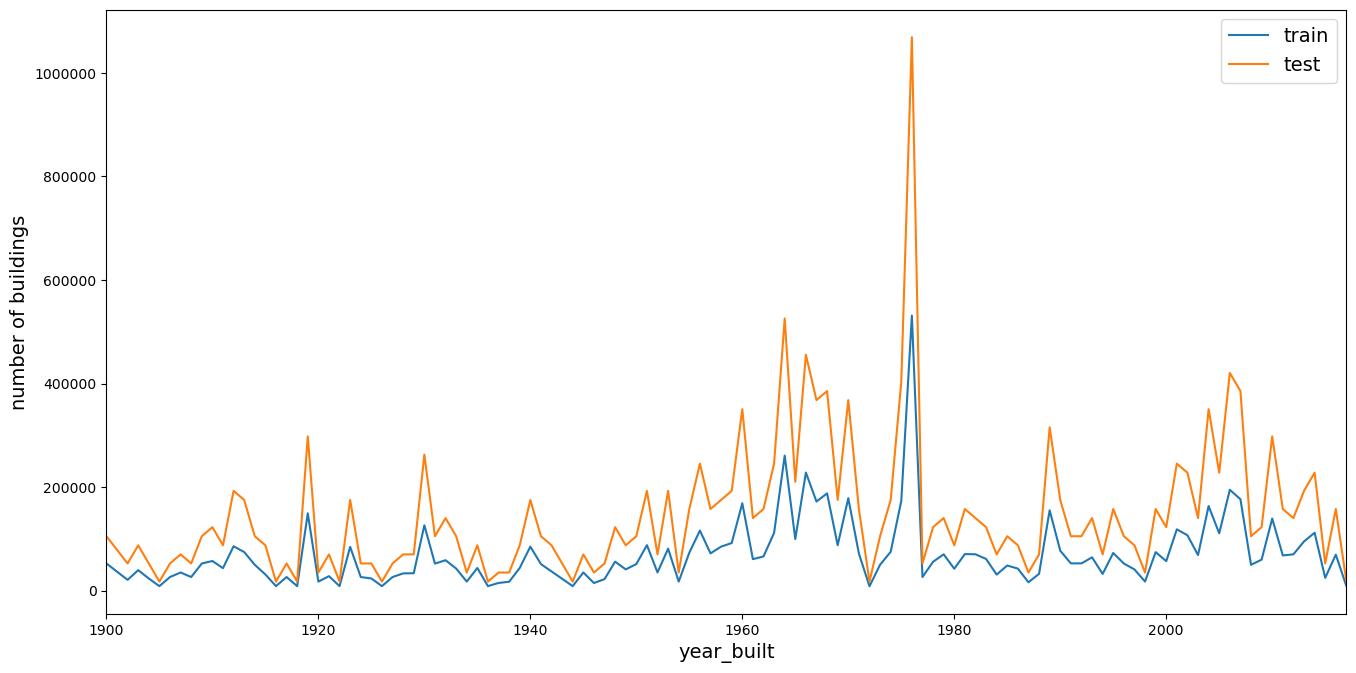

In [29]:
train_built = train['year_built'].value_counts(dropna=True).sort_index()
test_built = test['year_built'].value_counts(dropna=True).sort_index()

fig, ax = plt.subplots(1,1, figsize=(16,8), dpi=100)
train_built.plot(ax=ax)
test_built.plot(ax=ax)
ax.set_xlabel('year_built', fontsize=14)
ax.set_ylabel('number of buildings', fontsize=14)
ax.legend(['train', 'test'], fontsize=14)

Text(0.5, 1.0, 'Test')

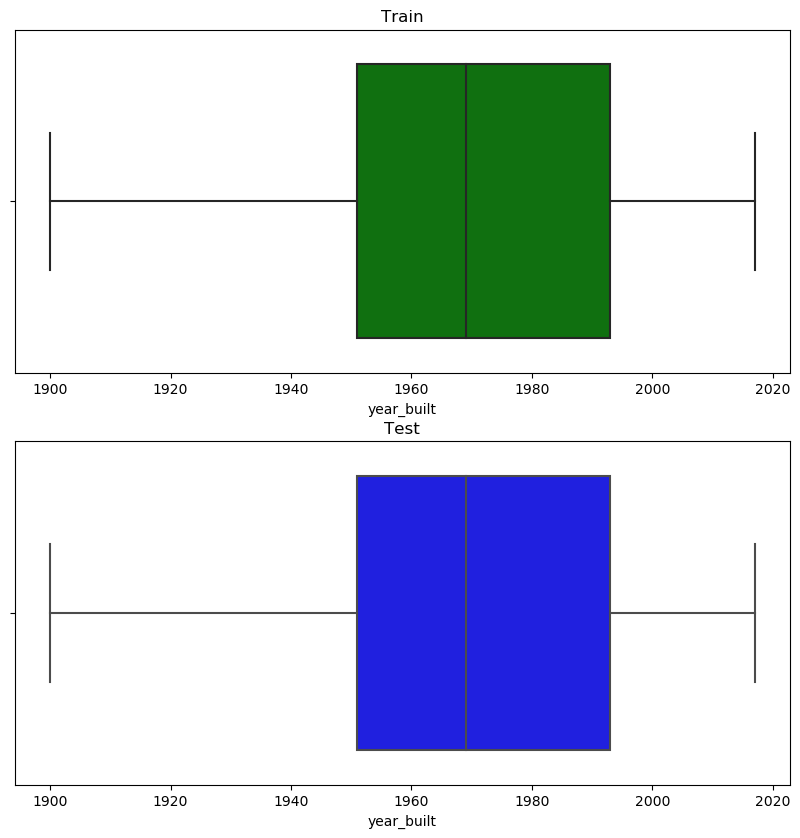

In [42]:
fig, axes = plt.subplots(2,1 ,figsize=(10,10), dpi=100)
sns.boxplot(x=train['year_built'], color='green', ax=axes[0])
sns.boxplot(x=test['year_built'], color='blue', ax=axes[1])
axes[0].set_title('Train', fontsize=12)
axes[1].set_title('Test', fontsize=12)

Text(0, 0.5, 'meter_reading')

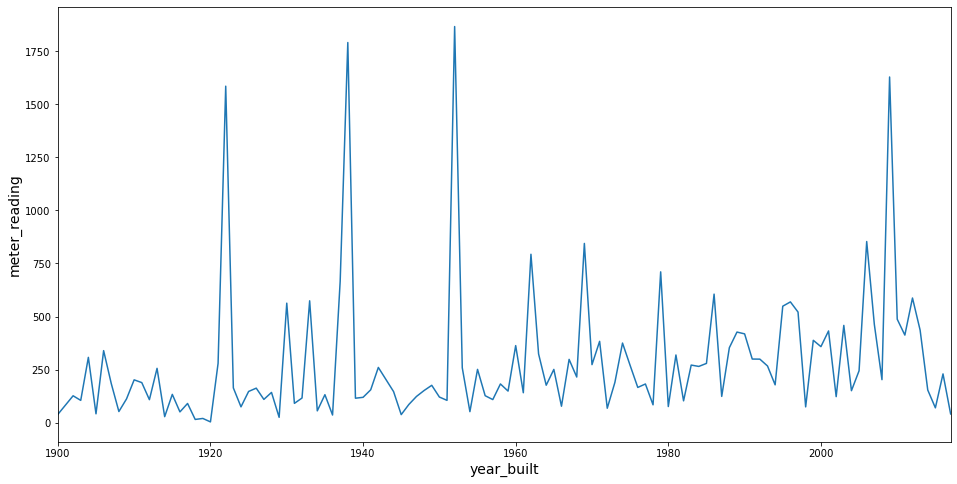

In [45]:
fig = plt.figure(figsize=(16,8))
ax = train.groupby('year_built')['meter_reading'].mean().plot()
ax.set_xlabel('year_built', fontsize=14)
ax.set_ylabel('meter_reading', fontsize=14)

## air_temperature

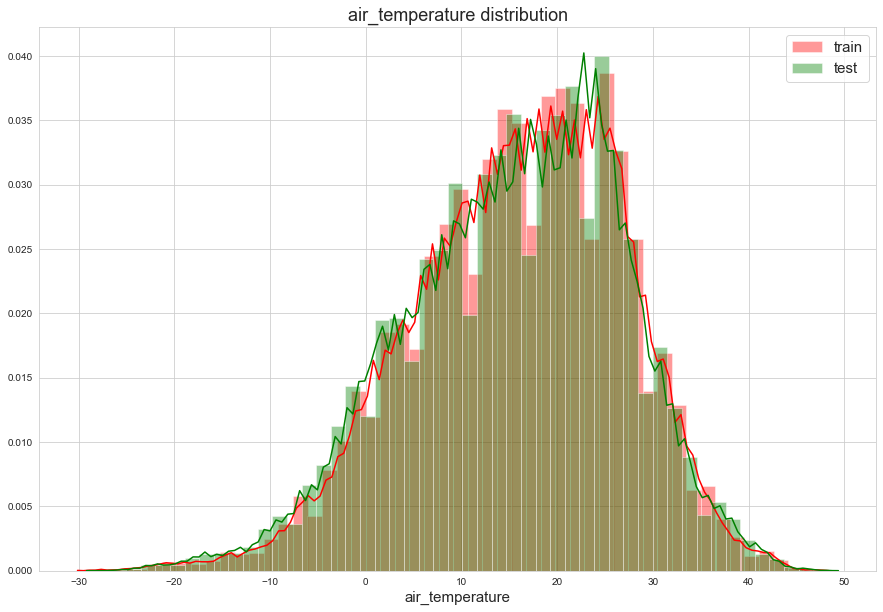

In [22]:
dist_plot('air_temperature')

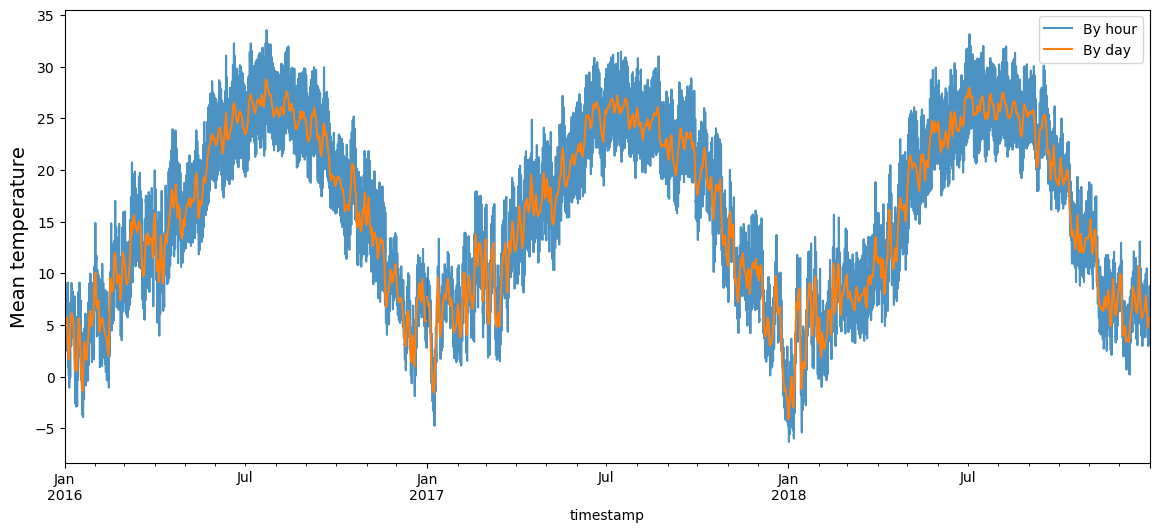

In [135]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean temperature', fontsize=14)
test[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes, alpha=0.8, color='tab:blue', label='')
train[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes, alpha=1, label='By day', color='tab:orange')
test[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes, alpha=1, color='tab:orange', label='')
axes.legend()


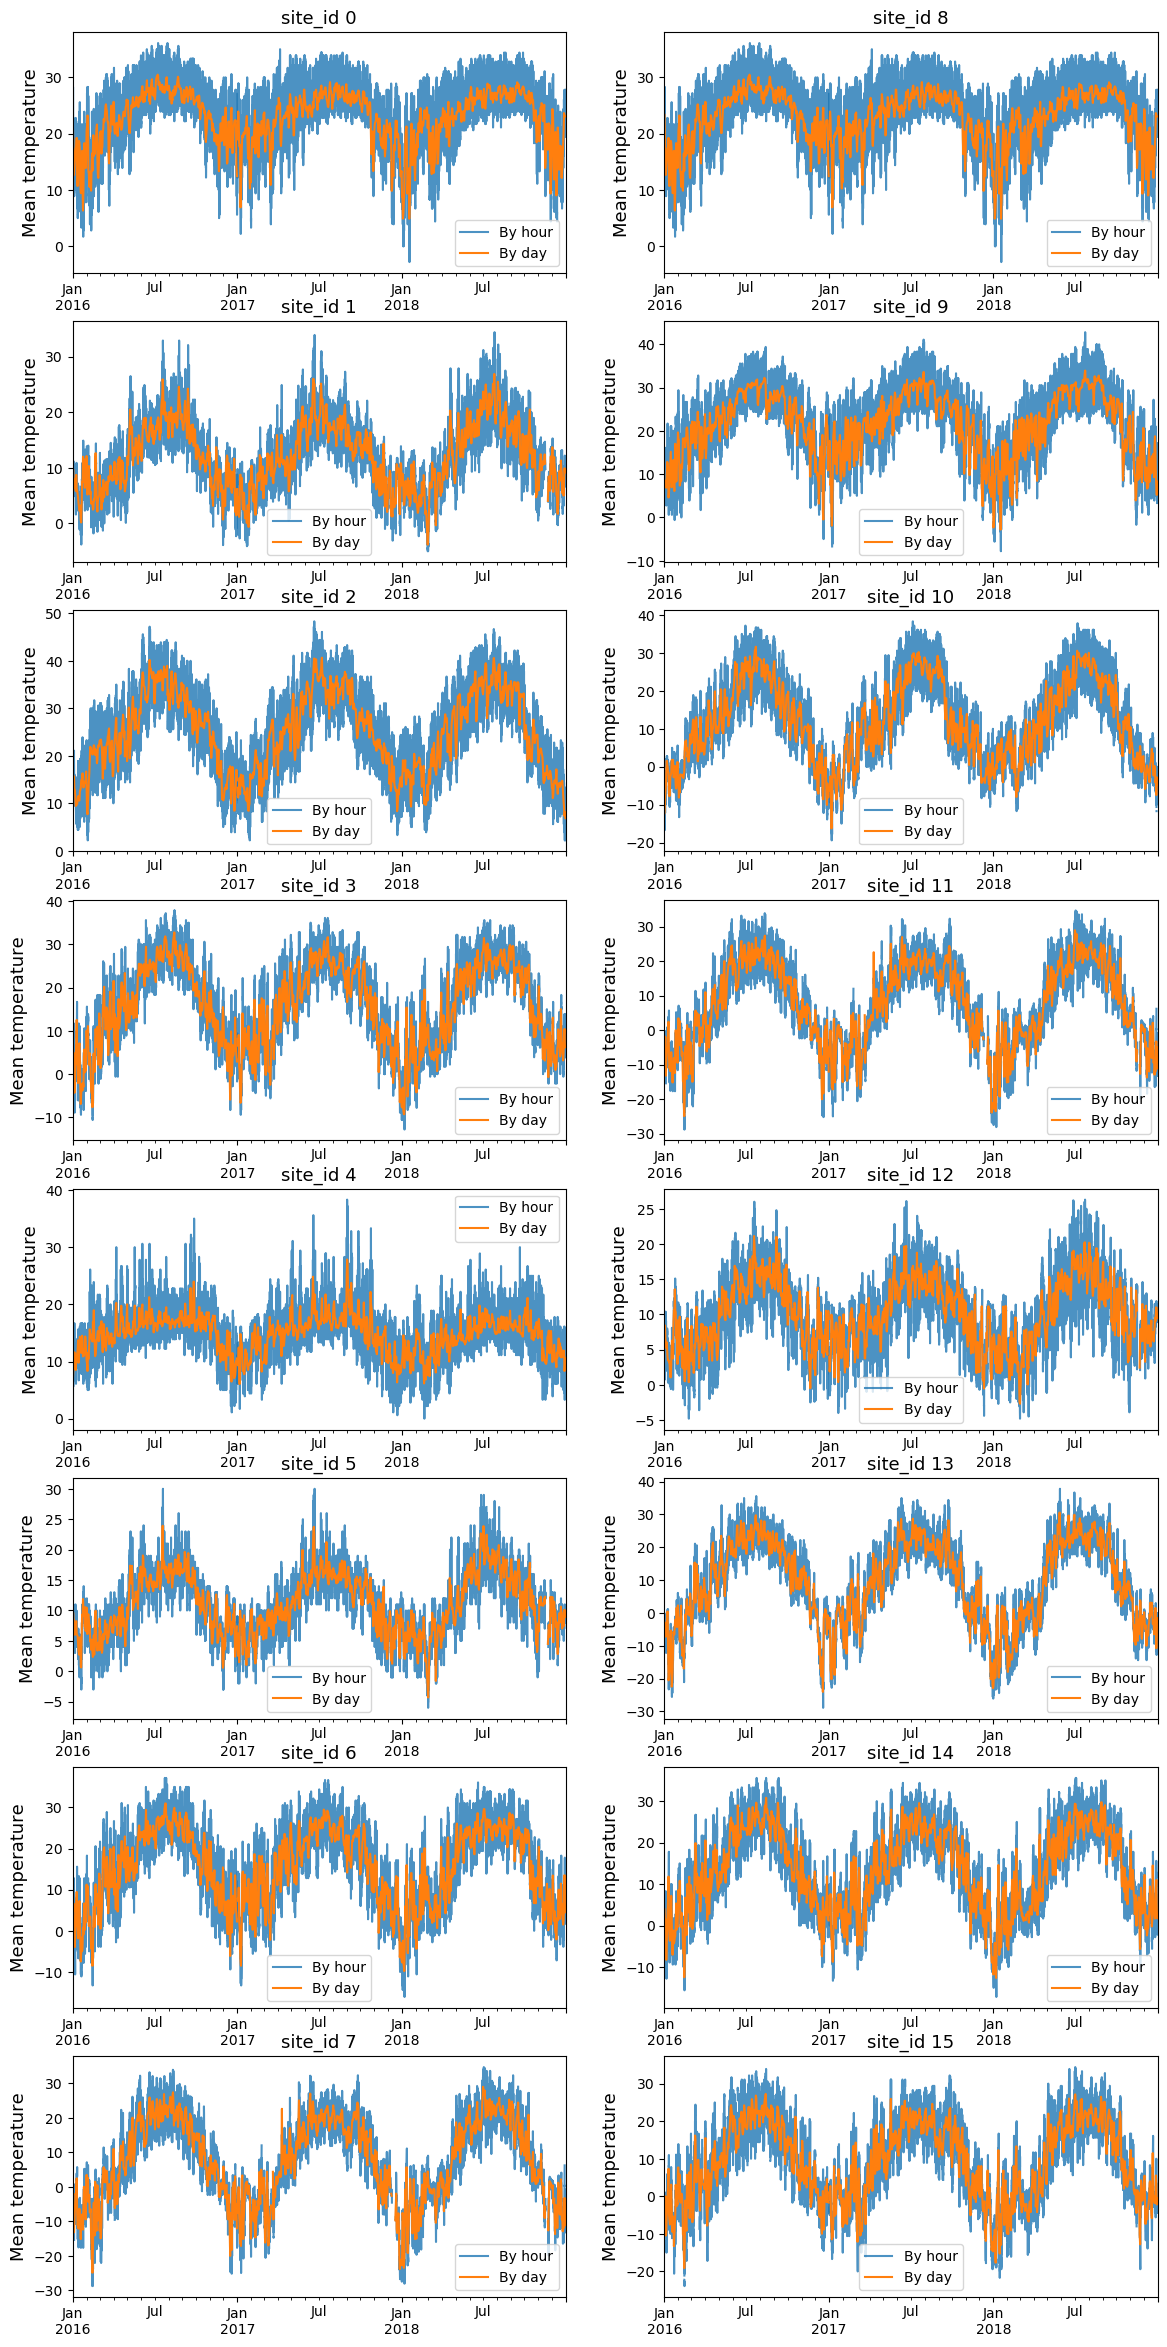

In [16]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean temperature', fontsize=13);
    test[test['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, color='tab:blue', label='').set_xlabel('')
    train[train['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange')
    test[test['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=1, color='tab:orange', label='').set_xlabel('')
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);

http://ww2010.atmos.uiuc.edu/(Gh)/guides/maps/sfcobs/dwp.rxml 

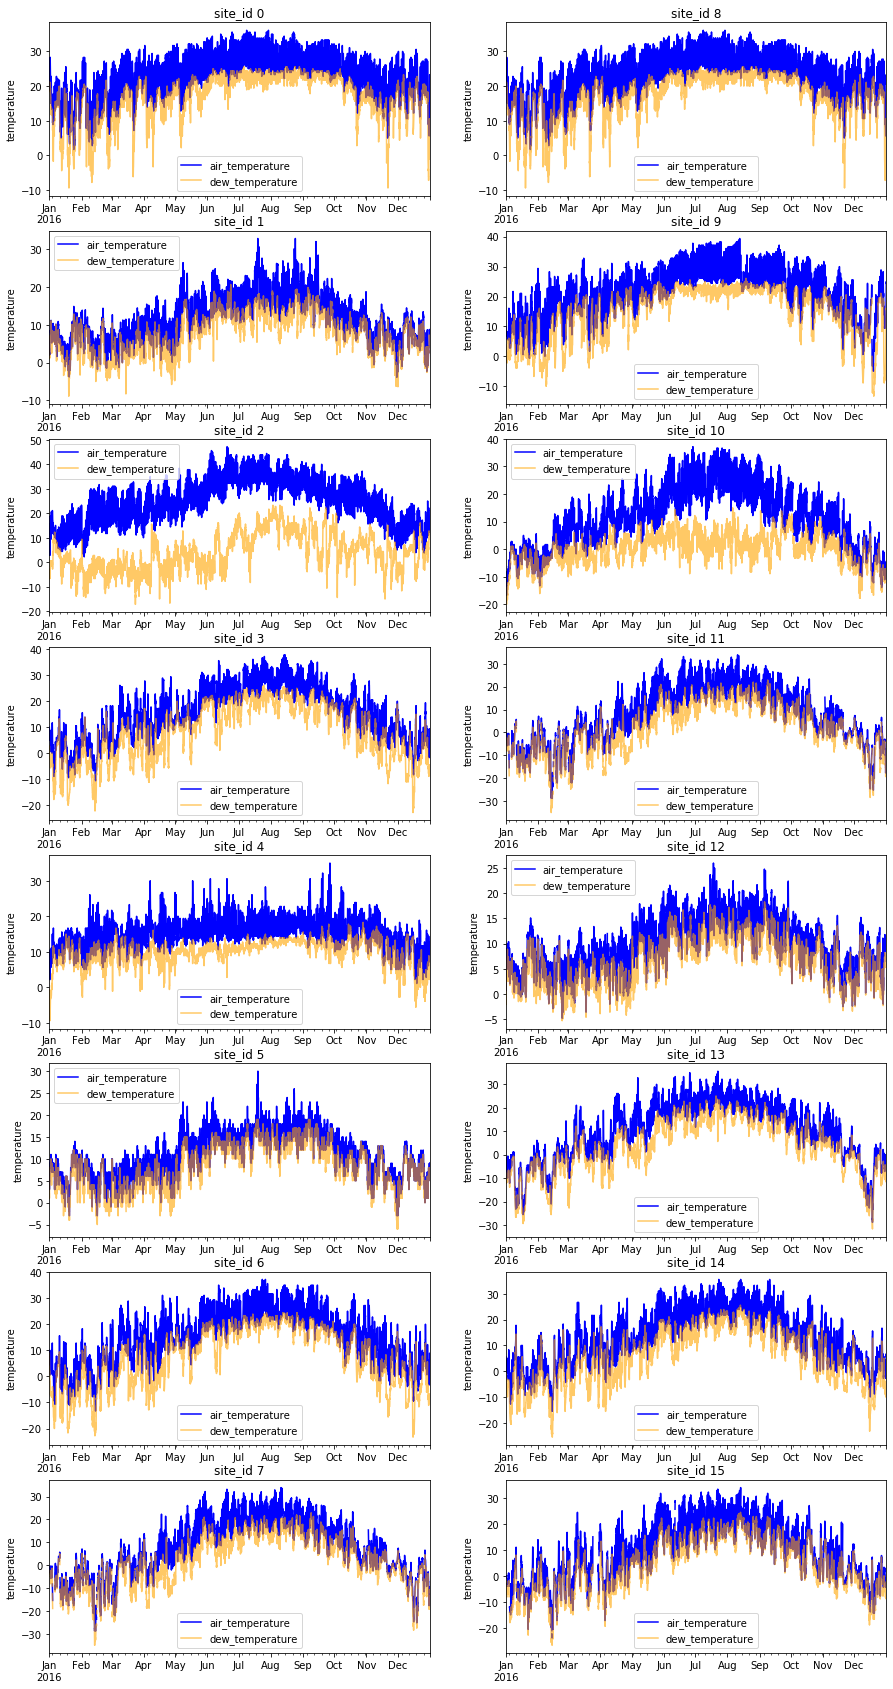

In [22]:
fig, axes = plt.subplots(8,2, figsize=(15,30))
for i in range(train['site_id'].nunique()):
    air_temp = train[train['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature']
    air_temp.plot(ax=axes[i%8][i//8], label='air_temperature', alpha=1, color='blue')
    dew = train[train['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature']
    dew.plot(ax=axes[i%8][i//8], label='dew_temperature', alpha=0.6, color='orange')
    axes[i%8][i//8].set_title('site_id {}' .format(i))
    axes[i%8][i//8].set_xlabel('')
    axes[i%8][i//8].set_ylabel('temperature')
    axes[i%8][i//8].tick_params(axis='y')
    axes[i%8][i//8].legend()
    

In [97]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

## cloud_coverage

In [100]:
train['cloud_coverage'].value_counts().sort_index()

0.0    5752501
1.0      25653
2.0    2431126
3.0      21866
4.0    1844497
5.0      18923
6.0     548557
7.0     125319
8.0     548105
9.0      74188
Name: cloud_coverage, dtype: int64

Text(0, 0.5, 'mean_meter_reading')

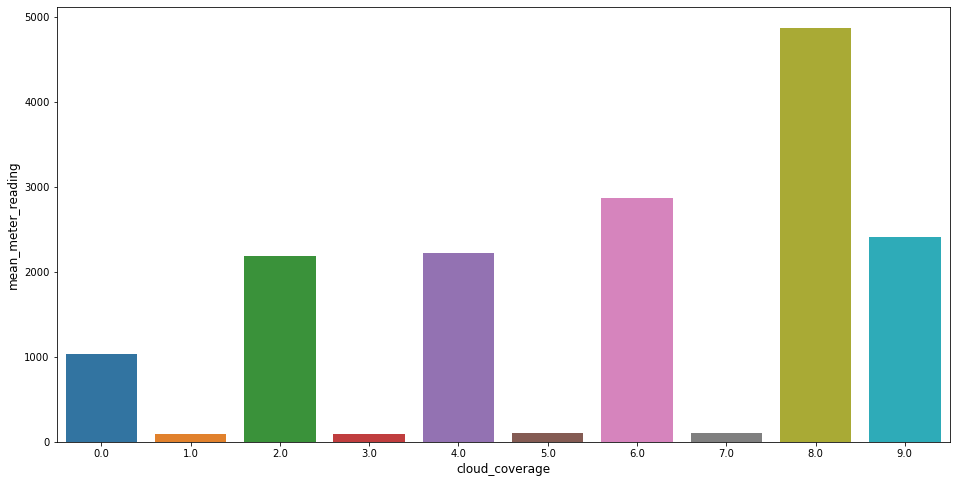

In [103]:
cloud = train.groupby('cloud_coverage')['meter_reading'].mean().sort_index()
cloud_df = pd.DataFrame({'cloud_coverage': cloud.index, 'mean_meter_reading': cloud.values})

fig = plt.figure(figsize=(16,8))
ax = sns.barplot(x='cloud_coverage', y='mean_meter_reading', data=cloud_df)
ax.set_xlabel('cloud_coverage', fontsize=12)
ax.set_ylabel('mean_meter_reading', fontsize=12)

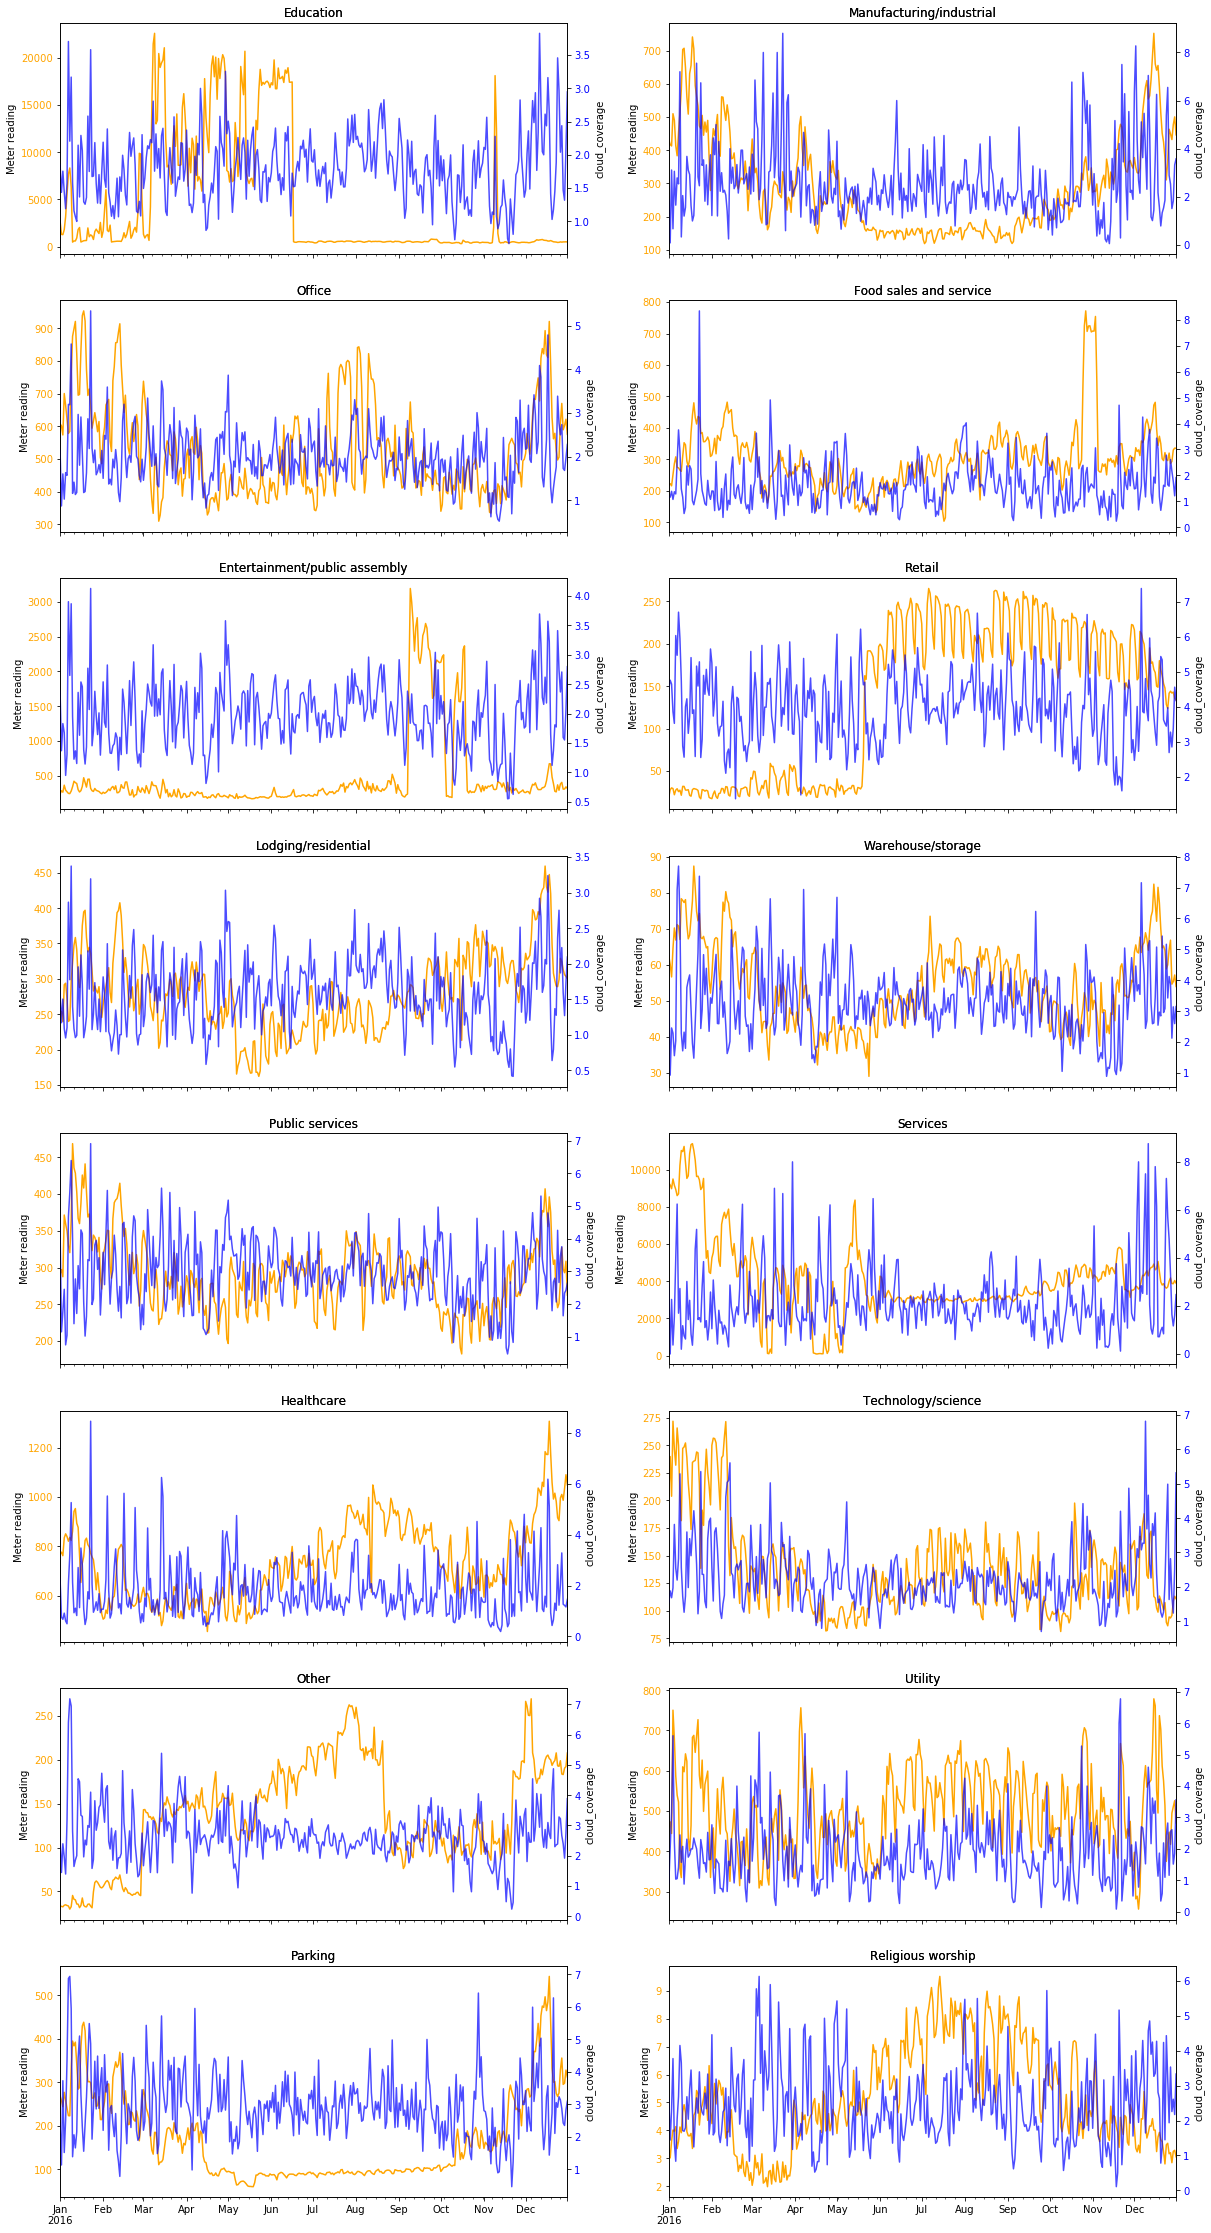

In [44]:
fig, axes = plt.subplots(8,2, figsize=(20,40))
axes2 = axes

for i, prim_use in enumerate(train['primary_use'].value_counts().index.to_list()):
    D = train[train['primary_use'] == prim_use][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading']
    D.plot(ax=axes[i%8][i//8], label='meter_reading', alpha=1, color='orange')
    axes[i%8][i//8].set_title('{}' .format(prim_use))
    axes[i%8][i//8].set_xlabel('')
    axes[i%8][i//8].set_ylabel('Meter reading')
    axes[i%8][i//8].tick_params(axis='y', labelcolor='orange')
    
    axes2[i%8][i//8] = axes[i%8][i//8].twinx()
    cld_cov = train[train['primary_use'] == prim_use][['timestamp', 'cloud_coverage']].set_index('timestamp').resample('D').mean()['cloud_coverage']
    cld_cov.plot(ax=axes2[i%8][i//8], label='cloud_coverage', alpha=0.7, color='blue')
    axes2[i%8][i//8].set_title('{}' .format(prim_use))
    axes2[i%8][i//8].set_xlabel('')
    axes2[i%8][i//8].set_ylabel('cloud_coverage')
    axes2[i%8][i//8].tick_params(axis='y', labelcolor='blue')
    


### investigate if cloud coverage affects bulidings with primary_use as "Manufacturing/industrial" and "Utility"

## precip_depth_1_hr

http://anzasca.net/wp-content/uploads/2015/12/005_Diaz-Sandoval_Osmond_King_ASA2015.pdf 

https://nrc-publications.canada.ca/eng/view/accepted/?id=b3873340-8c0a-472c-a9be-9d793be7cb2e

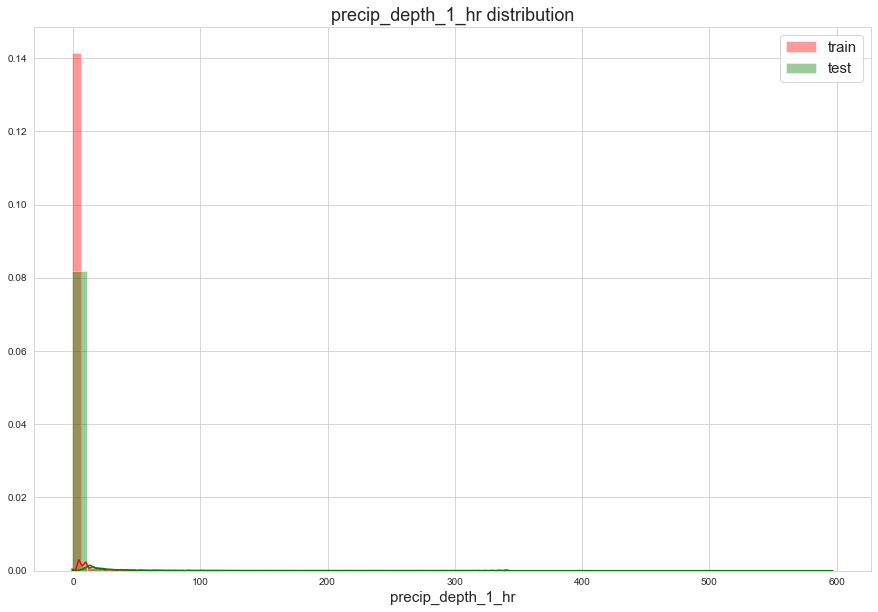

In [25]:
dist_plot('precip_depth_1_hr')

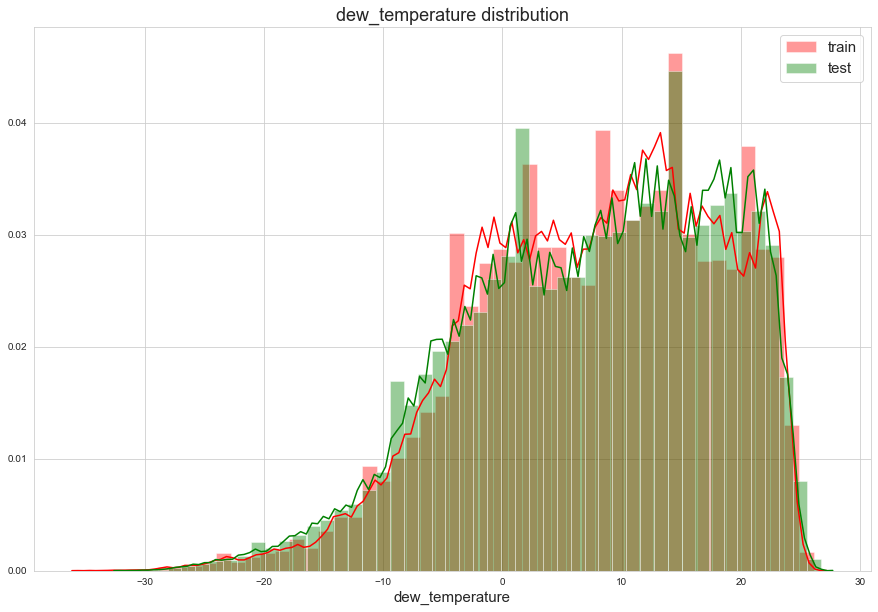

In [24]:
dist_plot('dew_temperature')

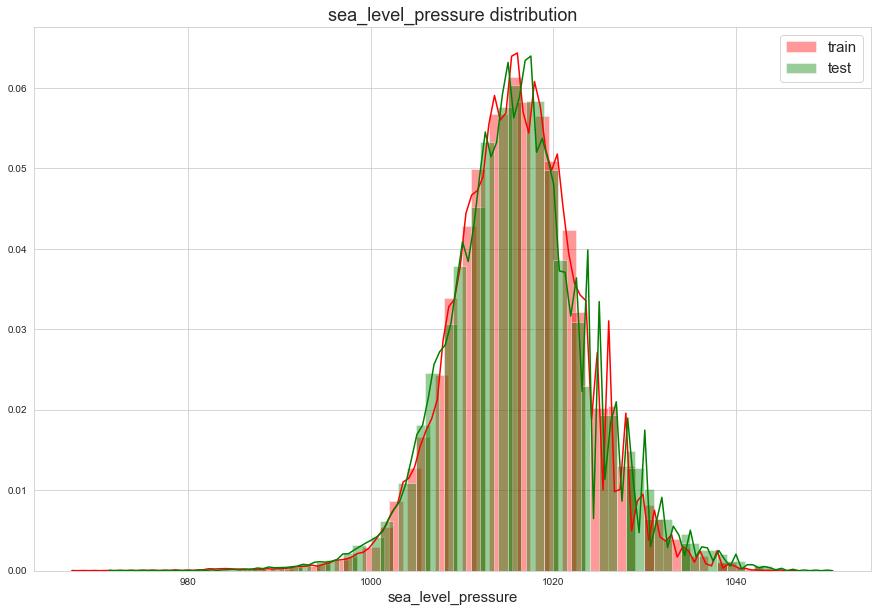

In [26]:
dist_plot('sea_level_pressure')

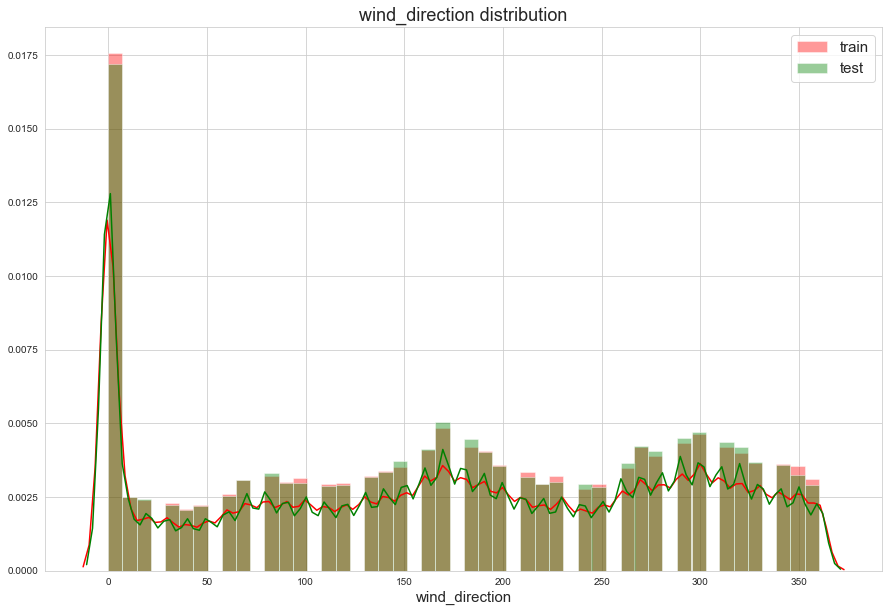

In [27]:
dist_plot('wind_direction')

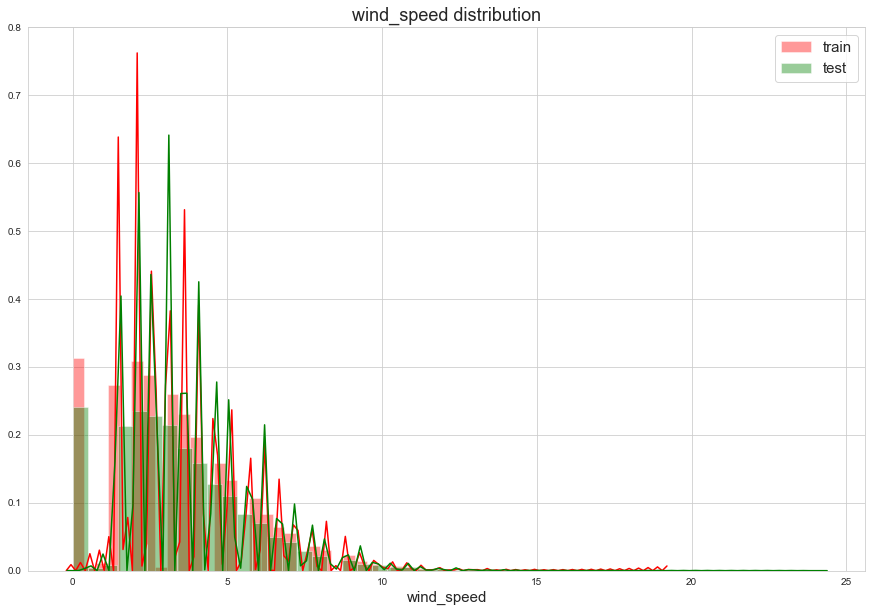

In [35]:
dist_plot('wind_speed')

In [56]:
test_meter_count = test['meter'].value_counts()
test_meter_per = test_meter_count/test['meter'].count()
meter_test = pd.concat([test_meter_count, test_meter_per], axis=1, keys=['Total','Percent'])
meter_test

Total   Percent
0  24755760  0.593697
1   8724960  0.209244
2   5676480  0.136134
3   2540400  0.060924